https://github.com/busesese/DeepFM_Keras/blob/master/DeepFM/deepfm.py

In [27]:
import numpy as np 
from keras.layers import Input, Dense, Embedding, Add, Concatenate, RepeatVector,Multiply,Subtract,Lambda,Dropout,Reshape,Flatten
from keras.models import Model
from keras.utils import plot_model
from mylayers import MySumLayer
from keras.optimizers import Adam
# import config
from keras.metrics import binary_accuracy
# from metrics import auc
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import LabelEncoder 
from keras.optimizers import *
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import Image
from keras.utils.vis_utils import model_to_dot

## Data Loading

In [28]:
import pandas as pd    
import gc
import os

df = pd.read_csv(os.path.join("..","..","data","YN_final_df2.csv"))
df.head()
# df = pd.read_csv(os.path.join("..","..","data","YN_final_df.csv"))
# df.head()

,rating,locationId,photonum,createdDate,is_fch,is_local,place.name,userID,average_photonum,average_rating,user_mean_rating,user_reviewcount,lat,lng,land.addr,category,rated_count,category_l
0,4.5,1150710065,0,2020-05-21 20:42:00,1,1,스타벅스 보라매공원R점,432293,0.164557,4.506329,4.5,1,37.492103,126.92355,"서울특별시 동작구 신대방동 395-65 파크스퀘어,보라매현대APT",EAT,158.0,1
1,5.0,1150710065,0,2019-06-28 01:11:03,1,1,스타벅스 보라매공원R점,135109,0.164557,4.506329,5.0,1,37.492103,126.92355,"서울특별시 동작구 신대방동 395-65 파크스퀘어,보라매현대APT",EAT,158.0,1
2,5.0,1150710065,0,2020-03-12 00:22:00,1,1,스타벅스 보라매공원R점,269138,0.164557,4.506329,5.0,1,37.492103,126.92355,"서울특별시 동작구 신대방동 395-65 파크스퀘어,보라매현대APT",EAT,158.0,1
3,5.0,1150710065,0,2020-02-16 17:06:00,1,1,스타벅스 보라매공원R점,246123,0.164557,4.506329,5.0,1,37.492103,126.92355,"서울특별시 동작구 신대방동 395-65 파크스퀘어,보라매현대APT",EAT,158.0,1
4,5.0,1150710065,0,2019-03-11 00:08:48,1,1,스타벅스 보라매공원R점,119248,0.164557,4.506329,5.0,1,37.492103,126.92355,"서울특별시 동작구 신대방동 395-65 파크스퀘어,보라매현대APT",EAT,158.0,1


### 로컬 / 글로벌 데이터 분리

In [29]:
# 로컬 / 글로벌 데이터 분리
local_df = df.loc[df['is_local']==1]
global_df = df.loc[df['is_local']==0]
print('local_df shape:',local_df.shape, 'global_df shape :',global_df.shape)

local_df shape: (381125, 18) global_df shape : (98566, 18)


In [30]:
# 로컬, 글로벌 공통 location id 뽑기
local_id = local_df['locationId'].unique().tolist()
global_id = global_df['locationId'].unique().tolist()

common_ids = []
for i in local_id:
    if i in global_id:
        common_ids.append(i)

common_acm = df.loc[df['locationId'].isin(common_ids)]
common_acm = common_acm.loc[common_acm['category']=='ACM']
common_acm_ids = common_acm['locationId'].unique().tolist()
# global, local 모두 담은 acm location ids
print(len(common_acm_ids)) 

245


### 장소 전처리

## 1. local

In [31]:
local_df_acm = local_df.loc[local_df['category'] == 'ACM']
local_df_eat = local_df.loc[local_df['category'] == 'EAT']

# 평균평점 이상의 식당만 남김.
local_df_eat = local_df_eat.loc[local_df_eat['average_rating']>=local_df_eat['average_rating'].median()]
local_df = pd.concat([local_df_acm, local_df_eat])

# local이기에 global과 차이를 두기위해 최대한 의미없는 체인 제거 
local_df = local_df.loc[local_df['is_fch']==0]

# 의미없는 추천 식당 제거 
fch_lst = ['연세대학교신촌캠펴스 웰스토리','써브웨이', '던킨도너츠','노브랜드버거','바르다김선생',' 폴바셋',' 안동찜닭',' 속초코다리냉면',' 할매순대국&양선지해장국',' 노브랜드버거 남부터미널점','바르다김선생' ,'유가네','24시 중식당 취빈','매머드커피','압구정봉구비어','카페베네','쥬씨','피자스쿨','매머드익스프레스','김밥천국','한국맥도날드','메머드커피','신전떡볶이','어사또', '공차', '북촌손만두', '오징어세상' ,'사월에보리밥', '땡스브레드엔커피', '피자몰', '나주소나주곰탕', '새마을식당','싸다김밥', '교동짬뽕', '토마토김밥', '화화쿵주마라탕', '샐러데이즈', '더차이','뚜레쥬르','스쿨푸드','자연별곡','죠스떡볶이','국대떡볶이', '도쿄스테이크','이디야커피', '코스트코코리아양재점푸드코트', '불고기브라더스','알라딘중고서점카페','배스킨라빈스','할리스커피', '와플대학', '파리바게뜨공덕역사', '파리바게뜨','아웃백','설빙', '봉추찜닭', '하겐다즈','아라마크연세의료원종합관']
fch_idx = local_df[local_df['place.name'].apply(lambda x: any(i in x for i in fch_lst))].index.tolist()
idx = local_df[local_df['place.name'].apply(lambda x: x[-1] == '점')].index.tolist()

for i in idx:
    if i not in fch_idx:
        fch_idx.append(i)

local_df = local_df.drop(fch_idx)
print('의미없을만한 식당 제거 후 local데이터 크기:',local_df.shape)

의미없을만한 식당 제거 후 local데이터 크기: (95248, 18)


In [32]:
# 데이터 저장
local_df.to_csv(os.path.join("..","realtime_model",'local_df(deepFM).csv'), index=False)

In [33]:
RANDOMSTATE = 2018

COLS=['locationId',  'createdDate', 'photonum', 'rated_count', 'average_photonum',
        'average_rating', 'user_mean_rating', 'user_reviewcount','userID' ] 

In [34]:
def get_data(column, df) :
    
    vocab = {}
    num = 0

    for i in df[column]: 
        if vocab.get(i) != None:
            continue

        vocab[i] = num
        num += 1

    encoded = [vocab[i] for i in df[column]]
    
    return encoded, num, vocab

encoded_locationId, num_locationId, vocab_locationId = get_data('locationId', local_df) 
encoded_createdDate,  num_createdDate, vocab_createdDate = get_data('createdDate', local_df) 
encoded_photonum,  num_photonum, vocab_photonum = get_data('photonum', local_df) 
encoded_rated_count,  num_rated_count, vocab_rated_count = get_data('rated_count', local_df) 
encoded_average_photonum,  num_average_photonum, vocab_average_photonum = get_data('average_photonum', local_df) 
encoded_average_rating,  num_average_rating, vocab_average_rating = get_data('average_rating', local_df) 
encoded_users_mean_rating, num_users_mean_rating, vocab_users_mean_rating = get_data('user_mean_rating', local_df) 
encoded_user_reviewcount,  num_user_reviewcount, vocab_user_reviewcount = get_data('user_reviewcount', local_df) 
encoded_userID, num_userID, vocab_userID = get_data('userID', local_df) 


feat_nu_dict = {}
feat_nu_dict['locationId'] = num_locationId
feat_nu_dict['createdDate'] = num_createdDate
feat_nu_dict['photonum'] = num_photonum
feat_nu_dict['rated_count'] = num_rated_count
feat_nu_dict['average_photonum'] = num_average_photonum
feat_nu_dict['average_rating'] = num_average_rating
feat_nu_dict['user_mean_rating'] = num_users_mean_rating
feat_nu_dict['user_reviewcount'] = num_user_reviewcount
feat_nu_dict['userID'] = num_userID
feat_nu_dict

{'locationId': 3845,
 'createdDate': 60497,
 'photonum': 32,
 'rated_count': 212,
 'average_photonum': 940,
 'average_rating': 834,
 'user_mean_rating': 10,
 'user_reviewcount': 6,
 'userID': 93949}

In [35]:
k = 8 #the number of embedding dim

input_cols = []
cols = []
embed_col = []
for col in COLS:
    in_neu = Input(shape=(1,), name=col) #None*1
    input_cols.append(in_neu)
    in_embed = RepeatVector(1, name='FM_'+col)(Dense(k)(in_neu)) #None*1*k
    cols.append(in_neu)
    embed_col.append(in_embed)
con_numeric = Concatenate(axis=1)(cols) #None*len(config.COLS)
dense_numeric = RepeatVector(1)(Dense(1)(con_numeric)) #None*1*1

In [36]:
# 모델 구조 아키텍쳐
#first order
y_first_order = dense_numeric #Concatenate(axis=1)([dense_numeric, con_cate]) #None*len*1
y_first_order = MySumLayer(axis=1)(y_first_order) #None*1

#second order
emb = Concatenate(axis=1)(embed_col) #None*s*k

summed_feature_emb = MySumLayer(axis=1)(emb) #None*k
summed_feature_emb_squred = Multiply()([summed_feature_emb,summed_feature_emb]) #None*k

squared_feature_emb = Multiply()([emb,emb]) #None*s*k
squared_sum_feature_emb = MySumLayer(axis=1)(squared_feature_emb) #None*k

sub = Subtract()([summed_feature_emb_squred,squared_sum_feature_emb]) #None*k
sub = Lambda(lambda x: x*0.5)(sub) #None*k
y_second_order = MySumLayer(axis=1)(sub)

#deep order
y_deep = Flatten()(emb) #None*(s*k)
y_deep = Dropout(0.5)(Dense(32,activation='relu')(y_deep)) #None*32
y_deep = Dropout(0.5)(Dense(32,activation='relu')(y_deep)) #None*32
y_deep = Dropout(0.2)(Dense(1,activation='relu')(y_deep)) #None*1

#deep fm
y = Concatenate()([y_first_order,y_second_order,y_deep]) #None*3
prediction = Dense(1,activation='sigmoid')(y)

In [37]:
from keras.callbacks import ModelCheckpoint

# 모델 저장 위치 설정 
model_save_path = os.path.join("..","..","data","model_weights")
if not os.path.exists(model_save_path):
    os.mkdir(model_save_path)

# 콜백모델 저장 -> 모델명 설정     
checkpoint_path = os.path.join(model_save_path ,"local_{epoch:02d}-{val_loss:.4f}.hdf5")
checkpoint_path_json = os.path.join(model_save_path ,"local_{epoch:02d}.json")

cb_checkpoint1 = ModelCheckpoint(filepath = checkpoint_path, monitor = 'val_loss', 
                                verbose=1, save_best_only=True, save_weights_only=True)
cb_checkpoint2 = ModelCheckpoint(filepath = checkpoint_path_json, monitor = 'val_loss', 
                                verbose=1, save_best_only=True, save_weights_only=True)

Train on 94771 samples, validate on 477 samples
Epoch 1/100
94771/94771 [==============================] - 1s 13us/step - loss: 13.2702 - auc_2: 0.0000e+00 - val_loss: 14.9748 - val_auc_2: 0.0000e+00

Epoch 00001: val_loss improved from inf to 14.97484, saving model to ../../data/model_weights/local_01-14.9748.hdf5

Epoch 00001: val_loss improved from inf to 14.97484, saving model to ../../data/model_weights/local_01.json
Epoch 2/100
94771/94771 [==============================] - 0s 4us/step - loss: 13.0425 - auc_2: 0.0000e+00 - val_loss: 14.9748 - val_auc_2: 0.0000e+00

Epoch 00002: val_loss did not improve from 14.97484

Epoch 00002: val_loss did not improve from 14.97484
Epoch 3/100
94771/94771 [==============================] - 0s 4us/step - loss: 13.0424 - auc_2: 0.0000e+00 - val_loss: 14.9748 - val_auc_2: 0.0000e+00

Epoch 00003: val_loss did not improve from 14.97484

Epoch 00003: val_loss did not improve from 14.97484
Epoch 4/100
94771/94771 [==============================] - 0


Epoch 00032: val_loss did not improve from 14.97484

Epoch 00032: val_loss did not improve from 14.97484
Epoch 33/100
94771/94771 [==============================] - 0s 4us/step - loss: 13.0432 - auc_2: 0.0000e+00 - val_loss: 14.9748 - val_auc_2: 0.0000e+00

Epoch 00033: val_loss did not improve from 14.97484

Epoch 00033: val_loss did not improve from 14.97484
Epoch 34/100
94771/94771 [==============================] - 0s 4us/step - loss: 13.0425 - auc_2: 0.0000e+00 - val_loss: 14.9748 - val_auc_2: 0.0000e+00

Epoch 00034: val_loss did not improve from 14.97484

Epoch 00034: val_loss did not improve from 14.97484
Epoch 35/100
94771/94771 [==============================] - 0s 4us/step - loss: 13.0426 - auc_2: 0.0000e+00 - val_loss: 14.9748 - val_auc_2: 0.0000e+00

Epoch 00035: val_loss did not improve from 14.97484

Epoch 00035: val_loss did not improve from 14.97484
Epoch 36/100
94771/94771 [==============================] - 0s 4us/step - loss: 13.0430 - auc_2: 0.0000e+00 - val_loss: 


Epoch 00064: val_loss did not improve from 14.97484

Epoch 00064: val_loss did not improve from 14.97484
Epoch 65/100
94771/94771 [==============================] - 0s 4us/step - loss: 13.0424 - auc_2: 0.0000e+00 - val_loss: 14.9748 - val_auc_2: 0.0000e+00

Epoch 00065: val_loss did not improve from 14.97484

Epoch 00065: val_loss did not improve from 14.97484
Epoch 66/100
94771/94771 [==============================] - 0s 5us/step - loss: 13.0424 - auc_2: 0.0000e+00 - val_loss: 14.9748 - val_auc_2: 0.0000e+00

Epoch 00066: val_loss did not improve from 14.97484

Epoch 00066: val_loss did not improve from 14.97484
Epoch 67/100
94771/94771 [==============================] - 0s 4us/step - loss: 13.0429 - auc_2: 0.0000e+00 - val_loss: 14.9748 - val_auc_2: 0.0000e+00

Epoch 00067: val_loss did not improve from 14.97484

Epoch 00067: val_loss did not improve from 14.97484
Epoch 68/100
94771/94771 [==============================] - 0s 4us/step - loss: 13.0428 - auc_2: 0.0000e+00 - val_loss: 


Epoch 00096: val_loss did not improve from 14.97484

Epoch 00096: val_loss did not improve from 14.97484
Epoch 97/100
94771/94771 [==============================] - 0s 4us/step - loss: 13.0427 - auc_2: 0.0000e+00 - val_loss: 14.9748 - val_auc_2: 0.0000e+00

Epoch 00097: val_loss did not improve from 14.97484

Epoch 00097: val_loss did not improve from 14.97484
Epoch 98/100
94771/94771 [==============================] - 0s 4us/step - loss: 13.0428 - auc_2: 0.0000e+00 - val_loss: 14.9748 - val_auc_2: 0.0000e+00

Epoch 00098: val_loss did not improve from 14.97484

Epoch 00098: val_loss did not improve from 14.97484
Epoch 99/100
94771/94771 [==============================] - 0s 4us/step - loss: 13.0430 - auc_2: 0.0000e+00 - val_loss: 14.9748 - val_auc_2: 0.0000e+00

Epoch 00099: val_loss did not improve from 14.97484

Epoch 00099: val_loss did not improve from 14.97484
Epoch 100/100
94771/94771 [==============================] - 0s 5us/step - loss: 13.0431 - auc_2: 0.0000e+00 - val_loss:

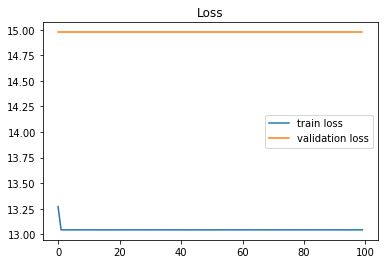

In [38]:
lr = 1e-1
epochs = 100
batch_size = 200000

model = Model(inputs=input_cols, outputs=prediction)
model.compile(loss="mse", optimizer=RMSprop(lr=lr), metrics=[tf.keras.metrics.AUC()])

history = model.fit([encoded_userID, encoded_users_mean_rating, 
                             encoded_user_reviewcount, encoded_locationId, 
                             encoded_createdDate, encoded_photonum,
                             encoded_rated_count,encoded_average_photonum, 
                             encoded_average_rating], local_df['rating'], 
                        batch_size=batch_size, epochs=epochs, validation_split=0.005,
                        callbacks = [cb_checkpoint1, cb_checkpoint2])


plt.plot(history.history["loss"], label="train loss")
plt.plot(history.history["val_loss"], label="validation loss")
plt.legend() 
plt.title("Loss")
plt.show()

In [39]:
# # 모델 불러오기 
# from keras.models import model_from_json 

# json_file = open(os.path.join(model_save_path ,"local_01.json"), "r",encoding="utf8", errors='ignore') 
# loaded_model_json = json_file.read() 
# json_file.close() 

# loaded_model = model_from_json(loaded_model_json)# ,custom_objects={'tf': tf, 'n_factors':8})

# loaded_model.load_weights(os.path.join(model_save_path,"local_01-12.3368.hdf5"))
                               
# print("Loaded model from disk")

# 유사도 아이템

In [40]:
def latent_to_vec(feature, model, location_df, h_size, input_features):
    layer_name = feature
    intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.get_layer(layer_name).output)
    test = input_features
                             
    locationId_latent_vector = intermediate_layer_model.predict(test)
    
    locationId_latent_vector = locationId_latent_vector.T.reshape(-1, h_size)
    vec = pd.DataFrame(locationId_latent_vector)
    location_df = location_df.reset_index()
    vec['locationId'] = location_df['locationId']
    
    # 아이템별 의미 벡터 생성 
    vec = vec.groupby('locationId').agg([('0','mean')]).reset_index()

    vec = pd.DataFrame(vec.iloc[:,1:].values)
    vec['locationId'] = location_df['locationId'].unique()
    vec = vec.set_index('locationId')
    return vec

In [41]:
vec = latent_to_vec('FM_locationId', model, local_df, 8, [encoded_userID, encoded_users_mean_rating, 
                             encoded_user_reviewcount, encoded_locationId, 
                             encoded_createdDate, encoded_photonum,
                        encoded_rated_count,
                                  encoded_average_photonum, encoded_average_rating])

In [42]:
vec.to_csv(os.path.join("..","realtime_model",'deepFM_local_vec.csv'))

In [43]:
from numpy import dot
from numpy.linalg import norm
import numpy as np
import random

def cosim_id(df, vec, item_id):
    def cos_sim(A, B):
           return dot(A, B)/(norm(A)*norm(B)) 
    new_vec = vec.copy() 
    sim = []
    
    # 인풋 호텔 정보 데이터에 없는 경우 종료 
    if item_id not in vec.index.tolist():
        return 
        
    for i in range(len(vec)):
        sim.append(cos_sim(vec.loc[item_id,:], vec.iloc[i,:]))

    new_vec['sim'] = sim
    # sim 높은 순 
    new_vec = new_vec['sim'].reset_index().sort_values('sim', ascending=False)
    sim_sorted = new_vec['locationId'].tolist()
    # 인풋 호텔정보 빼고 유사도 높은 순대로 id 
    if item_id in sim_sorted:
        sim_sorted.remove(item_id) 
    return sim_sorted 

def sim_item(vec, df, item_id, top):
    top_id = cosim_id(df, vec, item_id)
    
    if type(top_id) == list :
        df = df.drop_duplicates(['locationId'], keep='last')
        recommend_rst = []
        for x in top_id:
            if df.loc[df['locationId']==x].category.values[0]== 'EAT':
                recommend_rst.append([df.loc[df['locationId']==x][['place.name', 'land.addr']]])

        print('input hotel:', local_df.loc[local_df['locationId']==item_id]['place.name'].unique()[0])
        print('-'*10)
        for i in range(len(recommend_rst[:top])):
            print('top', i+1, recommend_rst[i][0]['place.name'].values[0])
            print('  주소', recommend_rst[i][0]['land.addr'].values[0])
        
    else:
        answer_lst = ['해당 호텔 정보가 없습니다. 다른 호텔을 입력해주세요.', '해당 호텔 정보가 없습니다. 다른 호텔을 추천받아보세요.']
        x = random.randint(0, len(answer_lst)-1)
        return answer_lst[x]
    

데이터 업뎃 후

In [44]:
import random

for location_id in common_acm_ids[:10]:
    print(sim_item(vec, local_df, location_id, 10))
    print()
    print()
    print()
    print('-'*50)

input hotel: 호텔에잇아워즈
----------
top 1 차오판
  주소 서울특별시 용산구 이태원동 129-2
top 2 키쏘커피 파랑헌
  주소 서울특별시 강남구 신사동 646-15
top 3 문화식당
  주소 서울특별시 성동구 성수동2가 310-21
top 4 육미전복
  주소 서울특별시 마포구 염리동 168-9 재화스퀘어
top 5 인도로가는길 레스토랑
  주소 서울특별시 종로구 관훈동 198-36 오원빌딩
top 6 소적두
  주소 서울특별시 강남구 신사동 660-18 원일
top 7 교동전선생
  주소 서울특별시 서초구 방배동 792-1
top 8 와삭통통닭강정
  주소 서울특별시 노원구 중계동 359-9 마들플라자
top 9 적당
  주소 서울특별시 중구 을지로1가 87 더존을지타워
top 10 와우신내떡
  주소 서울특별시 용산구 청파동3가 24-73
None



--------------------------------------------------
input hotel: 노보텔스위트앰배서더서울용산
----------
top 1 두레마을우동집
  주소 서울특별시 도봉구 창동 12
top 2 진성맷돼지
  주소 서울특별시 종로구 창신동 443-11
top 3 기절초풍왕순대
  주소 서울특별시 관악구 봉천동 1620-38
top 4 영일분식
  주소 서울특별시 영등포구 문래동4가 8-26
top 5 한솥도시락
  주소 서울특별시 마포구 상수동 324-7
top 6 제이와이 베이커리
  주소 서울특별시 강북구 수유동 32-2 수유중앙시장
top 7 차오판
  주소 서울특별시 용산구 이태원동 129-2
top 8 꾸띠 자르당
  주소 서울특별시 용산구 이태원동 131-23
top 9 맥주창고
  주소 서울특별시 동대문구 휘경동 319-8
top 10 명동식당
  주소 서울특별시 중구 묵정동 27-5
None



--------------------------------------------------
input hotel: 오리엔스호텔&

In [45]:
import random

for location_id in common_acm_ids[10:20]:
    print(sim_item(vec, local_df, location_id, 10))
    print()
    print()
    print()
    print('-'*50)

input hotel: 롯데시티호텔 마포
----------
top 1 코코부코
  주소 서울특별시 마포구 망원동 396-29
top 2 밀 베이커리
  주소 서울특별시 종로구 통인동 138-1
top 3 춘천골 숯불 닭갈비
  주소 서울특별시 관악구 신림동 1433-128
top 4 고창집
  주소 서울특별시 동대문구 청량리동 50-22
top 5 숙수도가
  주소 서울특별시 성북구 동소문동6가 158
top 6 나노기분식
  주소 서울특별시 은평구 녹번동 21-134
top 7 헬무트커피episode1
  주소 서울특별시 서초구 방배동 453-22
top 8 유가
  주소 서울특별시 중구 회현동1가 117-5
top 9 와플잇업
  주소 서울특별시 서대문구 대현동 27-17
top 10 호수보쌈족발
  주소 서울특별시 마포구 합정동 441-1
None



--------------------------------------------------
input hotel: 레스케이프 호텔
----------
top 1 소진담
  주소 서울특별시 강남구 신사동 551-23
top 2 남북통일
  주소 서울특별시 마포구 서교동 375-26
top 3 파이홀
  주소 서울특별시 서대문구 창천동 57-61
top 4 위고에빅토르
  주소 서울특별시 중구 을지로1가 132-2 롯데백화점 본점
top 5 횡성생고기집
  주소 서울특별시 노원구 공릉동 345-1
top 6 나노기분식
  주소 서울특별시 은평구 녹번동 21-134
top 7 상수동블루스
  주소 서울특별시 마포구 상수동 334-16
top 8 보성식당
  주소 서울특별시 동작구 사당동 1008-15
top 9 홀짝집
  주소 서울특별시 송파구 잠실동 193-4
top 10 담뿍담뿍
  주소 서울특별시 중구 을지로6가 18-12 두산타워빌딩
None



--------------------------------------------------
input hotel: 티마크그랜드호텔 명동
----------


In [46]:
import random

for location_id in common_acm_ids[20:30]:
    print(sim_item(vec, local_df, location_id, 10))
    print()
    print()
    print()
    print('-'*50)

input hotel: 강남아르누보시티
----------
top 1 장수가
  주소 서울특별시 종로구 관철동 33-13
top 2 부암동스코프
  주소 서울특별시 종로구 부암동 278-5
top 3 연어시장
  주소 서울특별시 노원구 월계동 63-5
top 4 더해윰
  주소 서울특별시 강동구 성내동 50-7
top 5 호 파스타
  주소 서울특별시 광진구 화양동 12-52
top 6 카페노아
  주소 서울특별시 종로구 인사동 263
top 7 베로나
  주소 서울특별시 중구 을지로3가 320-24
top 8 카펜스토리
  주소 서울특별시 중구 인현동1가 2-35 오일관광(주)호텔 피제이
top 9 나노기분식
  주소 서울특별시 은평구 녹번동 21-134
top 10 이치류
  주소 서울특별시 마포구 서교동 395-124
None



--------------------------------------------------
input hotel: TheK호텔 서울
----------
top 1 add coffee
  주소 서울특별시 중구 주교동 112
top 2 적당
  주소 서울특별시 중구 을지로1가 87 더존을지타워
top 3 옛날마차
  주소 서울특별시 양천구 신정동 904-6
top 4 빠꼬로꼬
  주소 서울특별시 용산구 이태원동 713
top 5 경성광장
  주소 서울특별시 송파구 송파동 57-3
top 6 이특집
  주소 서울특별시 광진구 구의동 53-13
top 7 숙수도가
  주소 서울특별시 성북구 동소문동6가 158
top 8 모나드 커피로스터스
  주소 서울특별시 금천구 시흥동 911-6
top 9 카페 스탐티쉬
  주소 서울특별시 종로구 부암동 258-5
top 10 농민백암왕순대
  주소 서울특별시 강남구 역삼동 830-9
None



--------------------------------------------------
input hotel: 롯데시티호텔 구로
----------
top 1 두레마을우동집
  주소 서울특별시 도봉

In [47]:
import random

for location_id in common_acm_ids[30:40]:
    print(sim_item(vec, local_df, location_id, 10))
    print()
    print()
    print()
    print('-'*50)

해당 호텔 정보가 없습니다. 다른 호텔을 입력해주세요.



--------------------------------------------------
input hotel: 글래드 여의도
----------
top 1 비사벌전주콩나물국밥
  주소 서울특별시 동대문구 장안동 429-3
top 2 담뿍화로된장찌개
  주소 서울특별시 서초구 서초동 1330-7 강남역 롯데골드로즈
top 3 황산샤브샤브
  주소 서울특별시 종로구 수송동 58 두산위브파빌리온
top 4 호 파스타
  주소 서울특별시 광진구 화양동 12-52
top 5 작은공간
  주소 서울특별시 강남구 역삼1동 823-19 K&I타워
top 6 서울부띠끄
  주소 서울특별시 중구 만리동1가 62-1 대양항공화물
top 7 봉평산골메밀촌
  주소 서울특별시 성동구 행당동 192-29 성동샤르망
top 8 안녕낯선사람
  주소 서울특별시 마포구 서교동 398-9
top 9 두부 마을
  주소 서울특별시 종로구 관훈동 38 쌈지길
top 10 일호면옥
  주소 서울특별시 영등포구 여의도동 36 롯데캐슬엠파이어
None



--------------------------------------------------
input hotel: 더스테이트 선유 호텔
----------
top 1 구름떡집
  주소 서울특별시 서초구 방배4동 815-1
top 2 숙수도가
  주소 서울특별시 성북구 동소문동6가 158
top 3 나노기분식
  주소 서울특별시 은평구 녹번동 21-134
top 4 유가
  주소 서울특별시 중구 회현동1가 117-5
top 5 고고갈비
  주소 서울특별시 마포구 상수동 310-14
top 6 교동전선생
  주소 서울특별시 서초구 방배동 792-1
top 7 돈불1971
  주소 서울특별시 서대문구 창천동 62-37
top 8 섭지코지
  주소 서울특별시 성북구 성북동 97-24
top 9 소디스커피
  주소 서울특별시 관악구 봉천동 1613-14 하나리버빌
top 10 커피기업
  주소

In [48]:
import random

for location_id in common_acm_ids[40:50]:
    print(sim_item(vec, local_df, location_id, 10))
    print()
    print()
    print()
    print('-'*50)

input hotel: 골든서울호텔
----------
top 1 더팀버하우스
  주소 서울특별시 강남구 대치동 995-14 호텔아이파크(주)
top 2 파파브레드
  주소 서울특별시 서대문구 북아현동 134-4
top 3 까미노빵집
  주소 서울특별시 강북구 수유동 564-6
top 4 벌떡
  주소 서울특별시 성북구 동선동2가 142-6
top 5 무너미
  주소 서울특별시 강북구 수유동 222-78
top 6 즐거운맛돈까스
  주소 error
top 7 나루주막
  주소 서울특별시 강서구 마곡동 759-1 두산더랜드타워
top 8 마시앤바시
  주소 서울특별시 용산구 청파동3가 109-16
top 9 카페유노
  주소 서울특별시 도봉구 방학동 718-7 이에스에이아파트
top 10 나주곰탕 노안집
  주소 서울특별시 광진구 광장동 484 광장현대3단지아파트
None



--------------------------------------------------
input hotel: 나인트리프리미어호텔 명동2
----------
top 1 양재커피
  주소 서울특별시 서초구 양재동 7-43 초석빌딩
top 2 횡성생고기집
  주소 서울특별시 노원구 공릉동 345-1
top 3 영주김밥
  주소 서울특별시 마포구 상암동 1597 사보이시티디엠씨
top 4 영덕회식당
  주소 서울특별시 중구 무교동 1 효령빌딩
top 5 서울웨스틴조선호텔 아리아
  주소 서울특별시 중구 소공동 87-1 서울 웨스틴조선호텔
top 6 일미집
  주소 서울특별시 용산구 후암동 194-3
top 7 만양순대국
  주소 서울특별시 관악구 중앙동 458-8
top 8 광화문더덕순대
  주소 서울특별시 종로구 당주동 38-1
top 9 남산커피집
  주소 서울특별시 중구 남산동2가 25-8
top 10 앤아더
  주소 서울특별시 성동구 성수동1가 668-104
None



--------------------------------------------------
input hotel

In [49]:
import random

for location_id in common_acm_ids[50:60]:
    print(sim_item(vec, local_df, location_id, 10))
    print()
    print()
    print()
    print('-'*50)

input hotel: 라마다호텔앤스위트서울남대문
----------
top 1 경성광장
  주소 서울특별시 송파구 송파동 57-3
top 2 모듈러
  주소 서울특별시 용산구 후암동 446
top 3 나노기분식
  주소 서울특별시 은평구 녹번동 21-134
top 4 해바라기정육식당
  주소 error
top 5 내고향횡성한우정육점식당
  주소 서울특별시 송파구 방이동 66-3 석촌씨티빌딩
top 6 고흥순대국머리고기
  주소 서울특별시 광진구 자양동 5-55
top 7 숙수도가
  주소 서울특별시 성북구 동소문동6가 158
top 8 춘천골 숯불 닭갈비
  주소 서울특별시 관악구 신림동 1433-128
top 9 계동피자
  주소 서울특별시 종로구 계동 82-1
top 10 블랑디저트카페
  주소 서울특별시 강동구 명일동 312-56
None



--------------------------------------------------
input hotel: 베스트웨스턴프리미어서울가든호텔
----------
top 1 더로지
  주소 서울특별시 중구 을지로5가 273-4 트레블로지 동대문 호텔
top 2 또와순두부수제비
  주소 서울특별시 노원구 상계동 323-32 산호빌딩
top 3 순식당
  주소 서울특별시 용산구 동자동 4-1
top 4 포비 광화문
  주소 서울특별시 종로구 청진동 268-2
top 5 일미락
  주소 서울특별시 양천구 목동 406-126
top 6 곱창흡입
  주소 서울특별시 강남구 역삼동 817-23
top 7 포제이
  주소 서울특별시 영등포구 당산동5가 11-33 당산디오빌
top 8 품차
  주소 서울특별시 강서구 방화동 886 김포공항, 롯데몰, 스카이시티
top 9 닭날다
  주소 서울특별시 마포구 합정동 427-7
top 10 오복수산 도산
  주소 서울특별시 강남구 신사동 666-25
None



--------------------------------------------------
input hotel: 머큐

In [50]:
import random

for location_id in common_acm_ids[60:70]:
    print(sim_item(vec, local_df, location_id, 10))
    print()
    print()
    print()
    print('-'*50)

input hotel: 강남패밀리호텔
----------
top 1 부암동스코프
  주소 서울특별시 종로구 부암동 278-5
top 2 모듈러
  주소 서울특별시 용산구 후암동 446
top 3 명가닭한마리
  주소 서울특별시 노원구 하계동 208-3
top 4 와우신내떡
  주소 서울특별시 용산구 청파동3가 24-73
top 5 굿모닝
  주소 서울특별시 종로구 관철동 7-12 동일빌딩
top 6 오양회참치
  주소 서울특별시 중구 정동 2-1 오양수산빌딩
top 7 경성광장
  주소 서울특별시 송파구 송파동 57-3
top 8 더고집
  주소 서울특별시 성북구 하월곡동 67-37 구원빌딩
top 9 와삭통통닭강정
  주소 서울특별시 노원구 중계동 359-9 마들플라자
top 10 후레쉬빌
  주소 서울특별시 강남구 대치동 999
None



--------------------------------------------------
input hotel: 아트리움바비엥2
----------
top 1 위고에빅토르
  주소 서울특별시 중구 을지로1가 132-2 롯데백화점 본점
top 2 설레임삼겹살
  주소 서울특별시 서대문구 창천동 57-40 낙원빌딩
top 3 명가닭한마리
  주소 서울특별시 노원구 하계동 208-3
top 4 남북통일
  주소 서울특별시 마포구 서교동 375-26
top 5 교대이층집
  주소 서울특별시 서초구 서초동 1571-18 청화빌딩
top 6 카펜스토리
  주소 서울특별시 중구 인현동1가 2-35 오일관광(주)호텔 피제이
top 7 어머니와고등어
  주소 서울특별시 마포구 서교동 407-19
top 8 광화문더덕순대
  주소 서울특별시 종로구 당주동 38-1
top 9 교동전선생
  주소 서울특별시 서초구 방배동 792-1
top 10 나노기분식
  주소 서울특별시 은평구 녹번동 21-134
None



--------------------------------------------------
input hotel: 오라카이 

In [51]:
import random

for location_id in common_acm_ids[70:80]:
    print(sim_item(vec, local_df, location_id, 10))
    print()
    print()
    print()
    print('-'*50)

input hotel: 인터시티365
----------
top 1 보쌈당한오징어
  주소 서울특별시 종로구 동숭동 1-89 석마빌딩
top 2 영천 떡볶이
  주소 서울특별시 서대문구 영천동 69-64
top 3 우동가조쿠
  주소 서울특별시 성동구 행당동 32-22
top 4 본죽
  주소 서울특별시 광진구 군자동 355-10
top 5 재화스퀘어 굴국밥 홍어 보쌈
  주소 서울특별시 마포구 염리동 168-9 재화스퀘어
top 6 더미노스
  주소 서울특별시 서초구 잠원동 18-5 주식회사 호텔 티롤
top 7 장블랑제리
  주소 서울특별시 관악구 봉천동 1660-6
top 8 씨포까페
  주소 서울특별시 강남구 신사동 530 동은프라자
top 9 웨스트진베이커리
  주소 서울특별시 양천구 목동 908-29 하이베라스
top 10 품차
  주소 서울특별시 강서구 방화동 886 김포공항, 롯데몰, 스카이시티
None



--------------------------------------------------
input hotel: Hotel in 9
----------
top 1 수르기
  주소 서울특별시 용산구 한남동 683-65
top 2 명화원
  주소 서울특별시 용산구 한강로1가 14-28
top 3 경성갈비
  주소 서울특별시 강남구 대치동 996-7
top 4 벱
  주소 서울특별시 성동구 성수동2가 321-21
top 5 금성관 나주곰탕
  주소 서울특별시 중구 남대문로3가 96 청남빌딩
top 6 방배유부김밥
  주소 서울특별시 서대문구 대현동 56-19
top 7 고심
  주소 서울특별시 마포구 서교동 345-27
top 8 카페인홀릭로스터스
  주소 서울특별시 영등포구 양평동2가 6-1 우남푸르미아오피스텔
top 9 한울푸드
  주소 서울특별시 영등포구 양평동5가 39 선유도 우림라이온스밸리 A
top 10 연죽
  주소 서울특별시 종로구 익선동 137-2
None



-------------------------------------

In [52]:
import random

for location_id in common_acm_ids[80:90]:
    print(sim_item(vec, local_df, location_id, 10))
    print()
    print()
    print()
    print('-'*50)

input hotel: G2 호텔
----------
top 1 버바나
  주소 서울특별시 마포구 동교동 197-15
top 2 광안리
  주소 서울특별시 마포구 서교동 396-44
top 3 이특집
  주소 서울특별시 광진구 구의동 53-13
top 4 내고향횡성한우정육점식당
  주소 서울특별시 송파구 방이동 66-3 석촌씨티빌딩
top 5 베스킨라빈스31
  주소 서울특별시 광진구 자양동 227-336 건국대학교동문회관
top 6 친친
  주소 서울특별시 마포구 서교동 343-9
top 7 맘모스커피
  주소 서울특별시 마포구 서교동 327-15
top 8 삼전회전초밥
  주소 서울특별시 종로구 당주동 15-7
top 9 오브엘
  주소 서울특별시 마포구 상암동 2-77
top 10 카펜스토리
  주소 서울특별시 중구 인현동1가 2-35 오일관광(주)호텔 피제이
None



--------------------------------------------------
input hotel: 서울 렉스 호텔
----------
top 1 숙수도가
  주소 서울특별시 성북구 동소문동6가 158
top 2 오근내2닭구이&닭갈비
  주소 서울특별시 용산구 한강로3가 40-9 용일빌딩
top 3 카페노아
  주소 서울특별시 종로구 인사동 263
top 4 쭉삼이
  주소 서울특별시 강동구 성내동 50-21
top 5 Blanc
  주소 서울특별시 마포구 동교동 173-14
top 6 백란다방
  주소 서울특별시 마포구 서교동 343-13
top 7 Deweet
  주소 서울특별시 마포구 연남동 260-14
top 8 영덕회식당
  주소 서울특별시 중구 무교동 1 효령빌딩
top 9 일미집
  주소 서울특별시 용산구 후암동 194-3
top 10 육미전복
  주소 서울특별시 마포구 염리동 168-9 재화스퀘어
None



--------------------------------------------------
input hotel: 라까사호텔 서울
---------

In [53]:
import random

for location_id in common_acm_ids[90:100]:
    print(sim_item(vec, local_df, location_id, 10))
    print()
    print()
    print()
    print('-'*50)

input hotel: 롯데 호텔 서울
----------
top 1 아티장 크로와상 - 북촌
  주소 서울특별시 종로구 계동 117-1
top 2 레자브르피아노의숲
  주소 서울특별시 마포구 서교동 397-10
top 3 옹기종기
  주소 서울특별시 성동구 용답동 98-4
top 4 적당
  주소 서울특별시 중구 을지로1가 87 더존을지타워
top 5 삼전회전초밥
  주소 서울특별시 종로구 당주동 15-7
top 6 치맛살
  주소 서울특별시 중구 신당동 381-15
top 7 브런치팩토리
  주소 서울특별시 강서구 마곡동 751 마곡엠밸리15단지
top 8 값진식육
  주소 서울특별시 영등포구 문래동3가 77-43
top 9 교대이층집
  주소 서울특별시 서초구 서초동 1571-18 청화빌딩
top 10 디저트연구소
  주소 서울특별시 마포구 서교동 332-32
None



--------------------------------------------------
input hotel: 이비스 스타일 앰배서더 서울 명동
----------
top 1 콩이랑두부랑
  주소 서울특별시 광진구 구의동 667 강변에스케이뷰
top 2 적당
  주소 서울특별시 중구 을지로1가 87 더존을지타워
top 3 썬파스타
  주소 서울특별시 강서구 화곡동 897-15
top 4 참족
  주소 서울특별시 강남구 도곡동 946-10
top 5 풀팬
  주소 서울특별시 강동구 천호동 427-3 천호엘크루주상복합
top 6 옛날마차
  주소 서울특별시 양천구 신정동 904-6
top 7 땅코참숯구이
  주소 서울특별시 노원구 상계동 348-4
top 8 채움
  주소 서울특별시 중구 남산동2가 30-1
top 9 고기사랑
  주소 서울특별시 서대문구 충정로3가 345
top 10 평원숯불갈비
  주소 서울특별시 종로구 효제동 174-6
None



--------------------------------------------------
input hotel: 인터컨티넨탈 서울

In [54]:
import random

for location_id in common_acm_ids[100:110]:
    print(sim_item(vec, local_df, location_id, 10))
    print()
    print()
    print()
    print('-'*50)

input hotel: 포시즌스 호텔 서울
----------
top 1 제로베이커리
  주소 서울특별시 송파구 방이동 35-8
top 2 케이리퍼블릭타파스바
  주소 서울특별시 용산구 이태원동 119-28
top 3 에베레스트 커리월드레스토랑
  주소 서울특별시 종로구 창신동 542
top 4 흥부골숯불돼지갈비
  주소 서울특별시 중구 신당동 393-2
top 5 카페 스탐티쉬
  주소 서울특별시 종로구 부암동 258-5
top 6 값진식육
  주소 서울특별시 영등포구 문래동3가 77-43
top 7 고고갈비
  주소 서울특별시 마포구 상수동 310-14
top 8 라이너스바베큐
  주소 서울특별시 용산구 이태원동 56-20
top 9 오브엘
  주소 서울특별시 마포구 상암동 2-77
top 10 몽소
  주소 서울특별시 용산구 청파동2가 90-18
None



--------------------------------------------------
input hotel: 호텔28 명동
----------
top 1 영주김밥
  주소 서울특별시 마포구 상암동 1597 사보이시티디엠씨
top 2 퍼퓰러
  주소 서울특별시 중구 을지로6가 23-9
top 3 육미전복
  주소 서울특별시 마포구 염리동 168-9 재화스퀘어
top 4 고찌소
  주소 서울특별시 서초구 방배본동 793-19
top 5 영덕회식당
  주소 서울특별시 중구 무교동 1 효령빌딩
top 6 몽소
  주소 서울특별시 용산구 청파동2가 90-18
top 7 로마옥
  주소 서울특별시 강남구 도곡동 948-13
top 8 소진담
  주소 서울특별시 강남구 신사동 551-23
top 9 부암동스코프
  주소 서울특별시 종로구 부암동 278-5
top 10 샤뽀 블랑
  주소 서울특별시 성북구 성북동 161-14
None



--------------------------------------------------
input hotel: 더 그랜드 호텔 명동
----------
top 1 북천

In [55]:
import random

for location_id in common_acm_ids[110:120]:
    print(sim_item(vec, local_df, location_id, 10))
    print()
    print()
    print()
    print('-'*50)

input hotel: 호텔 스카이파크 센트럴 명동
----------
top 1 모모카페 코트야드 서울 남대문
  주소 서울특별시 중구 남대문로4가 17-23 남대문호텔
top 2 카페타일링
  주소 서울특별시 금천구 독산동 967-7
top 3 최선생마라탕
  주소 서울특별시 마포구 상암동 1605 누리꿈스퀘어
top 4 코른베르그
  주소 서울특별시 송파구 문정동 150-1 올림픽훼밀리타운
top 5 가보리
  주소 서울특별시 중구 묵정동 28-1
top 6 승남집
  주소 서울특별시 영등포구 영등포동3가 21-3
top 7 성민 샤브샤브
  주소 서울특별시 관악구 봉천동 1627-9 고품격고시텔
top 8 독도수산
  주소 서울특별시 동작구 노량진동 13-6 노량진수산물도매시장
top 9 최우영스시
  주소 서울특별시 구로구 구로3동 212-8 대륭포스트타워1차
top 10 뱅뱅막국수
  주소 서울특별시 강남구 도곡동 943-2 서한빌딩
None



--------------------------------------------------
input hotel: 이코노미 호텔 명동 프리미어
----------
top 1 add coffee
  주소 서울특별시 중구 주교동 112
top 2 남북통일
  주소 서울특별시 마포구 서교동 375-26
top 3 콩이랑두부랑
  주소 서울특별시 광진구 구의동 667 강변에스케이뷰
top 4 와우신내떡
  주소 서울특별시 용산구 청파동3가 24-73
top 5 왕십리닭내장탕
  주소 서울특별시 광진구 화양동 20-1
top 6 숙수도가
  주소 서울특별시 성북구 동소문동6가 158
top 7 비사벌전주콩나물국밥
  주소 서울특별시 동대문구 장안동 429-3
top 8 문배동 육칼
  주소 서울특별시 강남구 삼성동 156-6
top 9 까페뷔에이
  주소 서울특별시 용산구 한남동 657-143
top 10 값진식육
  주소 서울특별시 영등포구 문래동3가 77-43
None



--------------------

In [56]:
import random

for location_id in common_acm_ids[120:130]:
    print(sim_item(vec, local_df, location_id, 10))
    print()
    print()
    print()
    print('-'*50)

input hotel: 을지로 코업레지던스
----------
top 1 토시리 현대백화점목동점 B2
  주소 서울특별시 양천구 목동 916 현대하이페리온
top 2 코리안숯불닭바베큐
  주소 서울특별시 종로구 숭인동 1257
top 3 맘맘테이블
  주소 서울특별시 서대문구 창천동 13-111
top 4 카페C
  주소 서울특별시 용산구 이촌동 301-54 한강교회
top 5 경천애인2237
  주소 서울특별시 영등포구 여의도동 45-1 SK증권빌딩
top 6 댓짱돈까스
  주소 서울특별시 양천구 목동 923-6 예술인회관
top 7 포비 광화문
  주소 서울특별시 종로구 청진동 268-2
top 8 포비 베이직
  주소 서울특별시 마포구 합정동 426-18
top 9 일미락
  주소 서울특별시 양천구 목동 406-126
top 10 나주곰탕 노안집
  주소 서울특별시 광진구 광장동 484 광장현대3단지아파트
None



--------------------------------------------------
input hotel: 사보이호텔
----------
top 1 모모카페 코트야드 서울 남대문
  주소 서울특별시 중구 남대문로4가 17-23 남대문호텔
top 2 낙원
  주소 서울특별시 관악구 신림동 1640-31 민속순대타운
top 3 팜티진쌀국수
  주소 서울특별시 성동구 도선동 69 성동삼성쉐르빌
top 4 이즈니베이커리
  주소 서울특별시 강남구 삼성동 159-7 현대백화점
top 5 함흥본가면옥
  주소 서울특별시 송파구 문정동 643-1 엠스테이트
top 6 돈오야
  주소 서울특별시 강서구 화곡동 346-1
top 7 사당광안리
  주소 서울특별시 동작구 사당동 1031-37
top 8 나인헤르츠
  주소 서울특별시 성동구 행당동 249-4
top 9 버섯집
  주소 서울특별시 성동구 성수동1가 668-34
top 10 그리디몬버거
  주소 서울특별시 영등포구 여의도동 17 여의도더샵아일랜드파크
None



-------------

In [57]:
import random

for location_id in common_acm_ids[130:140]:
    print(sim_item(vec, local_df, location_id, 10))
    print()
    print()
    print()
    print('-'*50)

input hotel: 트레블로지 명동 을지로호텔
----------
top 1 모모카페 코트야드 서울 남대문
  주소 서울특별시 중구 남대문로4가 17-23 남대문호텔
top 2 빠리가옥
  주소 서울특별시 종로구 익선동 166-26
top 3 등나무집
  주소 서울특별시 동작구 신대방동 687-14
top 4 더담다
  주소 서울특별시 서대문구 대현동 60-11
top 5 영천 떡볶이
  주소 서울특별시 서대문구 영천동 69-64
top 6 신촌찌개집
  주소 서울특별시 동작구 노량진동 126-11 서림독서실
top 7 우리김밥
  주소 서울특별시 강남구 신사동 550-19
top 8 소담정
  주소 서울특별시 송파구 방이동 63-4
top 9 밥한끼
  주소 서울특별시 용산구 한남동 72-17 언고오피스텔
top 10 박가네빈대떡
  주소 서울특별시 종로구 종로5가 138-10
None



--------------------------------------------------
input hotel: 호텔 스카이파크 명동 1
----------
top 1 개뿔
  주소 서울특별시 종로구 이화동 9-443
top 2 조박집 별관
  주소 서울특별시 마포구 용강동 43-2
top 3 영천 떡볶이
  주소 서울특별시 서대문구 영천동 69-64
top 4 신촌찌개집
  주소 서울특별시 동작구 노량진동 126-11 서림독서실
top 5 stdo
  주소 서울특별시 성동구 성수동1가 685-259 용빌딩
top 6 소공동뚝배기집
  주소 서울특별시 영등포구 여의도동 14-32 정원빌딩
top 7 후타리
  주소 서울특별시 광진구 중곡동 41-43
top 8 마천아구
  주소 서울특별시 강동구 명일동 344-15 에이플러스
top 9 교다이야
  주소 서울특별시 영등포구 당산동3가 314
top 10 공릉닭한마리
  주소 서울특별시 서대문구 대현동 104-69 부소빌딩
None



---------------------------------------------

In [58]:
import random

for location_id in common_acm_ids[140:150]:
    print(sim_item(vec, local_df, location_id, 10))
    print()
    print()
    print()
    print('-'*50)

input hotel: 호텔 통 서울 명동
----------
top 1 적당
  주소 서울특별시 중구 을지로1가 87 더존을지타워
top 2 헤이줄리
  주소 서울특별시 종로구 원남동 212-4
top 3 굿모닝
  주소 서울특별시 종로구 관철동 7-12 동일빌딩
top 4 미정
  주소 서울특별시 서대문구 연희동 192-29
top 5 간사이스타
  주소 서울특별시 영등포구 여의도동 14-21 엘지여의도에클라트
top 6 횡성생고기집
  주소 서울특별시 노원구 공릉동 345-1
top 7 샤뽀 블랑
  주소 서울특별시 성북구 성북동 161-14
top 8 빅세일
  주소 서울특별시 영등포구 여의도동 54-2 진주상가
top 9 내고향횡성한우정육점식당
  주소 서울특별시 송파구 방이동 66-3 석촌씨티빌딩
top 10 경성상회
  주소 서울특별시 동작구 노량진동 13-6 노량진수산물도매시장
None



--------------------------------------------------
input hotel: 호텔 마누
----------
top 1 모모카페 코트야드 서울 남대문
  주소 서울특별시 중구 남대문로4가 17-23 남대문호텔
top 2 봉메밀
  주소 서울특별시 강동구 길동 176-2
top 3 몽소
  주소 서울특별시 동작구 대방동 394-7 대방동빌딩
top 4 홍대 닭갈비(N)
  주소 서울특별시 마포구 서교동 357-2
top 5 김가네설악추어탕
  주소 서울특별시 종로구 연건동 91-1
top 6 카페 사브레
  주소 서울특별시 송파구 송파동 27-3
top 7 북천
  주소 서울특별시 용산구 한강로2가 153-8
top 8 반달곰문화공간
  주소 서울특별시 서대문구 창천동 5-21
top 9 마부자생삼겹살
  주소 서울특별시 강서구 마곡동 760 마곡나루역보타닉푸르지오시티
top 10 삭떡복이
  주소 서울특별시 마포구 상수동 315-8
None



-------------------------------------------

In [59]:
import random

for location_id in common_acm_ids[150:160]:
    print(sim_item(vec, local_df, location_id, 10))
    print()
    print()
    print()
    print('-'*50)

input hotel: 글로리 인
----------
top 1 평원숯불갈비
  주소 서울특별시 종로구 효제동 174-6
top 2 자연축산
  주소 서울특별시 성동구 마장동 509-3
top 3 설레임삼겹살
  주소 서울특별시 서대문구 창천동 57-40 낙원빌딩
top 4 로마옥
  주소 서울특별시 강남구 도곡동 948-13
top 5 육미전복
  주소 서울특별시 마포구 염리동 168-9 재화스퀘어
top 6 더 라운지
  주소 서울특별시 중구 소공동 1 롯데호텔
top 7 명가닭한마리
  주소 서울특별시 노원구 하계동 208-3
top 8 진화쿵푸마라탕
  주소 서울특별시 마포구 동교동 164-19
top 9 유가
  주소 서울특별시 중구 회현동1가 117-5
top 10 만양순대국
  주소 서울특별시 관악구 중앙동 458-8
None



--------------------------------------------------
input hotel: 크레토 호텔 명동
----------
top 1 진성맷돼지
  주소 서울특별시 종로구 창신동 443-11
top 2 맹순이꽃게아구찜
  주소 서울특별시 강서구 내발산동 644-2 하바나빌딩
top 3 정신
  주소 서울특별시 중구 북창동 77-2
top 4 샐러드 브라더스
  주소 서울특별시 마포구 동교동 154-5
top 5 구름떡집
  주소 서울특별시 서초구 방배4동 815-1
top 6 평원숯불갈비
  주소 서울특별시 종로구 효제동 174-6
top 7 혜화도담
  주소 서울특별시 종로구 명륜4가 48-2
top 8 커피기업
  주소 서울특별시 종로구 수송동 156 G타워
top 9 설레임삼겹살
  주소 서울특별시 서대문구 창천동 57-40 낙원빌딩
top 10 로마옥
  주소 서울특별시 강남구 도곡동 948-13
None



--------------------------------------------------
input hotel: 호텔 봉봉
----------
top 1 테라참치
  주소 서

In [60]:
import random

for location_id in common_acm_ids[160:170]:
    print(sim_item(vec, local_df, location_id, 10))
    print()
    print()
    print()
    print('-'*50)

input hotel: 뉴 오리엔탈 호텔
----------
top 1 빠꼬로꼬
  주소 서울특별시 용산구 이태원동 713
top 2 소적두
  주소 서울특별시 강남구 신사동 660-18 원일
top 3 스위트앤카츠
  주소 서울특별시 광진구 군자동 373-7
top 4 광화문더덕순대
  주소 서울특별시 종로구 당주동 38-1
top 5 강릉형제장칼국수
  주소 서울특별시 관악구 신림동 246-37
top 6 쉐라톤디큐브시티호텔FEAST
  주소 서울특별시 구로구 신도림동 692 디큐브시티
top 7 에빗
  주소 서울특별시 강남구 역삼동 791-15
top 8 돈키
  주소 서울특별시 서초구 반포동 816 주공반포아파트종합상가
top 9 이치류
  주소 서울특별시 마포구 서교동 395-124
top 10 봉평산골메밀촌
  주소 서울특별시 성동구 행당동 192-29 성동샤르망
None



--------------------------------------------------
input hotel: 토모 레지던스
----------
top 1 횡성생고기집
  주소 서울특별시 노원구 공릉동 345-1
top 2 카페키이로
  주소 서울특별시 종로구 명륜4가 154-2
top 3 문배동 육칼
  주소 서울특별시 강남구 삼성동 156-6
top 4 만양순대국
  주소 서울특별시 관악구 중앙동 458-8
top 5 맥주창고
  주소 서울특별시 동대문구 휘경동 319-8
top 6 더해윰
  주소 서울특별시 강동구 성내동 50-7
top 7 add coffee
  주소 서울특별시 중구 주교동 112
top 8 독수리다방
  주소 서울특별시 서대문구 창천동 31-4 독수리빌딩
top 9 내고향횡성한우정육점식당
  주소 서울특별시 송파구 방이동 66-3 석촌씨티빌딩
top 10 와플잇업
  주소 서울특별시 서대문구 대현동 27-17
None



--------------------------------------------------
input hotel: 에이큐브 

In [61]:
import random

for location_id in common_acm_ids[170:180]:
    print(sim_item(vec, local_df, location_id, 10))
    print()
    print()
    print()
    print('-'*50)

input hotel: 글래드 라이브 강남
----------
top 1 비스타 워커힐 서울 피자힐
  주소 서울특별시 광진구 광장동 22-1 워커힐호텔
top 2 멜로우시티
  주소 서울특별시 동대문구 전농동 567-25
top 3 몰토베네
  주소 서울특별시 마포구 합정동 361-20
top 4 와플반트
  주소 서울특별시 서초구 반포동 865 구반포상가
top 5 22FEB
  주소 서울특별시 강남구 논현동 254-30
top 6 녹기 전에
  주소 서울특별시 종로구 익선동 120
top 7 밥향기
  주소 서울특별시 송파구 가락동 77-4 송파KCC웰츠타워
top 8 벌교영양추어탕
  주소 서울특별시 종로구 명륜3가 2-24
top 9 인왕산 대충유원지
  주소 서울특별시 종로구 누하동 22
top 10 바다해물포차
  주소 서울특별시 서초구 방배동 951-31
None



--------------------------------------------------
input hotel: 로얄 호텔 서울
----------
top 1 깐족깐족
  주소 서울특별시 관악구 봉천동 1655-7
top 2 죽이네 스시
  주소 서울특별시 중구 충무로3가 30-17
top 3 김수사
  주소 서울특별시 강남구 논현동 4-19 해정빌딩
top 4 진지아
  주소 서울특별시 송파구 송파동 23-10
top 5 진미생태
  주소 서울특별시 마포구 용강동 508 e편한세상 마포3차
top 6 코이크
  주소 서울특별시 마포구 연남동 255-23
top 7 챔프커피
  주소 서울특별시 중구 산림동 207-2 대림상가
top 8 모모카페 코트야드 서울 남대문
  주소 서울특별시 중구 남대문로4가 17-23 남대문호텔
top 9 최선생마라탕
  주소 서울특별시 마포구 상암동 1605 누리꿈스퀘어
top 10 황금유황오리 부추덕
  주소 서울특별시 강남구 수서동 713 수서현대벤쳐빌
None



-------------------------------------

In [62]:
import random

for location_id in common_acm_ids[180:190]:
    print(sim_item(vec, local_df, location_id, 10))
    print()
    print()
    print()
    print('-'*50)

input hotel: 호텔 더 디자이너스 홍대
----------
top 1 범가
  주소 서울특별시 광진구 광장동 257-3
top 2 다락
  주소 서울특별시 마포구 도화동 340 에어몰 빌딩
top 3 메종프랭크
  주소 서울특별시 성동구 성수동1가 22-25
top 4 A3BOUT COFFEE
  주소 서울특별시 동작구 노량진동 116-2 한성빌딩
top 5 슬로우브레드파파
  주소 서울특별시 성북구 동선동2가 142-2
top 6 비옥
  주소 서울특별시 마포구 연남동 228-34 미소빌딩
top 7 합정고깃집
  주소 서울특별시 마포구 합정동 392-3
top 8 블랑제리11-17
  주소 서울특별시 강동구 성내동 78-1 강동메디컬센터
top 9 빠오즈푸
  주소 서울특별시 광진구 군자동 361-32
top 10 빵의정석
  주소 서울특별시 성동구 성수동1가 668-49
None



--------------------------------------------------
input hotel: 센터마크 호텔
----------
top 1 뺑도르
  주소 서울특별시 송파구 석촌동 293-3 남영빌딩
top 2 전주콩나물국밥
  주소 서울특별시 동대문구 휘경동 191-5
top 3 김기철의장수왕만두
  주소 서울특별시 관악구 봉천동 861-11
top 4 황소집
  주소 서울특별시 종로구 숭인동 227-7
top 5 스시쟁이
  주소 서울특별시 강동구 천호동 429-4
top 6 백미주반
  주소 서울특별시 성동구 성수동2가 301-66 용호빌딩
top 7 뽕식이네김밥
  주소 서울특별시 송파구 신천동 17-4 파크리오
top 8 난장캠프
  주소 서울특별시 강남구 논현동 198-3
top 9 종로설렁탕
  주소 서울특별시 종로구 창신동 444-9 임진빌딩
top 10 김밥나라
  주소 서울특별시 종로구 종로6가 83
None



--------------------------------------------------
input hotel: 

In [63]:
import random

for location_id in common_acm_ids[190:200]:
    print(sim_item(vec, local_df, location_id, 10))
    print()
    print()
    print()
    print('-'*50)

input hotel: 메트로 호텔
----------
top 1 카페몰로
  주소 서울특별시 동대문구 회기동 57-11
top 2 배프로갈비
  주소 서울특별시 마포구 노고산동 49-54
top 3 까치산족발보쌈
  주소 서울특별시 강서구 화곡동 341-59
top 4 더멜팅팟
  주소 서울특별시 관악구 봉천동 1613-4
top 5 즐거운맛돈까스
  주소 error
top 6 리바
  주소 서울특별시 광진구 광장동 22-1 워커힐호텔
top 7 63베이커리
  주소 서울특별시 영등포구 여의도동 60 63한화생명빌딩
top 8 공릉닭한마리
  주소 서울특별시 서대문구 대현동 104-69 부소빌딩
top 9 다락
  주소 서울특별시 마포구 도화동 340 에어몰 빌딩
top 10 메종프랭크
  주소 서울특별시 성동구 성수동1가 22-25
None



--------------------------------------------------
input hotel: JW 메리어트 호텔 서울
----------
top 1 마시앤바시
  주소 서울특별시 용산구 청파동3가 109-16
top 2 황제참치
  주소 서울특별시 종로구 묘동 193-1
top 3 까치산족발보쌈
  주소 서울특별시 강서구 화곡동 341-59
top 4 위트러스트커피 게이샤랩
  주소 서울특별시 마포구 도화동 182-5
top 5 대원앤대원
  주소 서울특별시 영등포구 여의도동 36-4 오륜빌딩
top 6 블랑제리11-17
  주소 서울특별시 강동구 성내동 78-1 강동메디컬센터
top 7 훅트포케
  주소 서울특별시 중구 을지로2가 101-30
top 8 고래국수
  주소 서울특별시 마포구 동교동 170-33
top 9 소미미단팥빵
  주소 서울특별시 강남구 역삼동 858 강남역
top 10 내가떡볶이다
  주소 서울특별시 종로구 효제동 318-1
None



--------------------------------------------------
input hotel: 메이 플레이스 서울

In [64]:
import random

for location_id in common_acm_ids[200:210]:
    print(sim_item(vec, local_df, location_id, 10))
    print()
    print()
    print()
    print('-'*50)

input hotel: 호텔 아트리움
----------
top 1 숙수도가
  주소 서울특별시 성북구 동소문동6가 158
top 2 레자브르피아노의숲
  주소 서울특별시 마포구 서교동 397-10
top 3 차오판
  주소 서울특별시 용산구 이태원동 129-2
top 4 수입식당
  주소 서울특별시 강남구 역삼동 828-52
top 5 돌쇠감자탕순대국
  주소 서울특별시 강서구 염창동 272-8
top 6 부암동스코프
  주소 서울특별시 종로구 부암동 278-5
top 7 브런치 뷰
  주소 서울특별시 종로구 익선동 117
top 8 장원닭한마리
  주소 서울특별시 동대문구 답십리동 488-326
top 9 카페키이로
  주소 서울특별시 종로구 명륜4가 154-2
top 10 간사이스타
  주소 서울특별시 영등포구 여의도동 14-21 엘지여의도에클라트
None



--------------------------------------------------
input hotel: 호텔 스카이파크 동대문 I
----------
top 1 엄마손칼국수
  주소 서울특별시 노원구 상계동 111-478
top 2 농민백암왕순대
  주소 서울특별시 강남구 역삼동 830-9
top 3 카페그레도
  주소 서울특별시 성북구 석관동 168-23 진성38 빌딩
top 4 양재커피
  주소 서울특별시 서초구 양재동 7-43 초석빌딩
top 5 문배동 육칼
  주소 서울특별시 강남구 삼성동 156-6
top 6 더고집
  주소 서울특별시 성북구 하월곡동 67-37 구원빌딩
top 7 레자브르피아노의숲
  주소 서울특별시 마포구 서교동 397-10
top 8 호타루
  주소 서울특별시 성동구 성수동1가 13-317
top 9 명동식당
  주소 서울특별시 중구 묵정동 27-5
top 10 카페부미
  주소 서울특별시 종로구 와룡동 131
None



--------------------------------------------------
input hotel: 선샤인 호텔
---

In [65]:
import random

for location_id in common_acm_ids[210:220]:
    print(sim_item(vec, local_df, location_id, 10))
    print()
    print()
    print()
    print('-'*50)

input hotel: 알로프트 서울 강남
----------
top 1 소담정
  주소 서울특별시 송파구 방이동 63-4
top 2 커피빈
  주소 서울특별시 중구 명동1가 1-3 YWCA연합회
top 3 그린버킷
  주소 서울특별시 영등포구 여의도동 32-1
top 4 본솔커피
  주소 서울특별시 용산구 청파동2가 64-13
top 5 동숭동커피
  주소 서울특별시 종로구 동숭동 130-63
top 6 스시토라
  주소 서울특별시 양천구 목동 405-241
top 7 고래국수
  주소 서울특별시 마포구 동교동 170-33
top 8 수르기
  주소 서울특별시 용산구 한남동 683-65
top 9 오모가리김치찌개
  주소 서울특별시 강남구 역삼동 738-1 역삼동JESS
top 10 카페인홀릭로스터스
  주소 서울특별시 영등포구 양평동2가 6-1 우남푸르미아오피스텔
None



--------------------------------------------------
input hotel: 호텔 페이토 강남
----------
top 1 대원칼국수
  주소 서울특별시 광진구 구의동 243-17 청도빌딩
top 2 그린버킷
  주소 서울특별시 영등포구 여의도동 32-1
top 3 도사 바이 백승욱
  주소 서울특별시 강남구 청담동 92-12 파크빌딩
top 4 경천애인2237
  주소 서울특별시 영등포구 여의도동 45-1 SK증권빌딩
top 5 범가
  주소 서울특별시 광진구 광장동 257-3
top 6 햇쌀마루
  주소 서울특별시 서초구 서초동 1364
top 7 더멜팅팟
  주소 서울특별시 관악구 봉천동 1613-4
top 8 왜이래 양푼씨
  주소 서울특별시 송파구 오금동 129-20
top 9 차담소
  주소 서울특별시 종로구 청진동 146 르메이에르종로타운1
top 10 Neue Atmung
  주소 서울특별시 강남구 신사동 559-9
None



--------------------------------------------------
input

In [66]:
import random

for location_id in common_acm_ids[220:230]:
    print(sim_item(vec, local_df, location_id, 10))
    print()
    print()
    print()
    print('-'*50)

input hotel: 인더시티 서비스 레지던스 강남
----------
top 1 채선당
  주소 서울특별시 종로구 숭인동 76 롯데캐슬 천지인
top 2 원조제일어버이순대
  주소 서울특별시 용산구 갈월동 98-52
top 3 희카롱
  주소 서울특별시 강남구 대치동 901-13
top 4 챔프커피
  주소 서울특별시 중구 산림동 207-2 대림상가
top 5 중앙해장
  주소 서울특별시 강남구 대치동 996-16 육인빌딩
top 6 덕후선생
  주소 서울특별시 강남구 청담동 85-2 유리빌딩
top 7 굿모닝
  주소 서울특별시 종로구 견지동 87-1 웅지빌딩
top 8 박가부대
  주소 서울특별시 성동구 성수동2가 333-140 서울숲코오롱디지탈타워
top 9 맛짱
  주소 서울특별시 송파구 신천동 17-4 파크리오
top 10 대치동 함흥면옥
  주소 서울특별시 강남구 대치동 1023-2 지산빌딩
None



--------------------------------------------------
input hotel: 센트럴 관광호텔
----------
top 1 오가와
  주소 서울특별시 종로구 당주동 5 로얄빌딩
top 2 스시홍
  주소 서울특별시 마포구 신공덕동 171 마포케이씨씨웰츠타워
top 3 함흥본가면옥
  주소 서울특별시 송파구 문정동 643-1 엠스테이트
top 4 커피상호작용
  주소 서울특별시 강남구 역삼동 607-12 JW빌딩
top 5 쭈꾸미 한상
  주소 서울특별시 강남구 논현동 144
top 6 썰스데이파티
  주소 서울특별시 용산구 이태원동 124-6
top 7 산들
  주소 서울특별시 광진구 군자동 98 세종대학교
top 8 우디집
  주소 서울특별시 성동구 성수동1가 314
top 9 로라멘
  주소 서울특별시 영등포구 문래동2가 14-15
top 10 Poolside Barbeque, Grand Hyatt Seoul
  주소 error
None



----------------------------------

In [67]:
import random

for location_id in common_acm_ids[230:240]:
    print(sim_item(vec, local_df, location_id, 10))
    print()
    print()
    print()
    print('-'*50)

input hotel: 리버사이드 호텔 서울
----------
top 1 중앙해장
  주소 서울특별시 강남구 대치동 996-16 육인빌딩
top 2 까치산족발보쌈
  주소 서울특별시 강서구 화곡동 341-59
top 3 바라붐
  주소 서울특별시 용산구 한남동 683-40
top 4 버섯집
  주소 서울특별시 성동구 성수동1가 668-34
top 5 마포즉석모밀촌
  주소 서울특별시 마포구 합정동 449-5
top 6 채선당
  주소 서울특별시 종로구 숭인동 76 롯데캐슬 천지인
top 7 동강나루터
  주소 서울특별시 중구 수표동 56-10 백양빌딩
top 8 왓쇼이켄
  주소 서울특별시 강남구 역삼동 826-37 쌍용플래티넘밸류
top 9 미정국수0410
  주소 서울특별시 동작구 노량진동 116-2 한성빌딩
top 10 무너미
  주소 서울특별시 강북구 수유동 222-78
None



--------------------------------------------------
input hotel: 글래드 강남 코엑스 센터
----------
top 1 코지빌라커피
  주소 서울특별시 용산구 이태원동 74-45
top 2 왜이래 양푼씨
  주소 서울특별시 송파구 오금동 129-20
top 3 Jogaechon
  주소 error
top 4 슈바벤
  주소 서울특별시 도봉구 방학동 676-21 SYO빌딩
top 5 버섯잔치집
  주소 서울특별시 강동구 성내동 549-4 성원빌딩
top 6 해피브레드
  주소 서울특별시 송파구 잠실동 208-7
top 7 즉석우동짜장
  주소 서울특별시 영등포구 신길동 4216
top 8 리플로우
  주소 서울특별시 마포구 동교동 197-15
top 9 미정국수0410
  주소 서울특별시 동작구 노량진동 116-2 한성빌딩
top 10 연남토마
  주소 서울특별시 마포구 연남동 568-26
None



--------------------------------------------------
input hotel: 몽호텔

In [17]:
sim_item(vec, local_df, 3477158, 10)

input hotel: 콘래드 서울
----------
top 1 카멜커피
  주소 서울특별시 강남구 청담동 113-13
top 2 용두삼겹살쭈꾸미
  주소 서울특별시 광진구 중곡동 115-4
top 3 그릴드300
  주소 서울특별시 마포구 동교동 150-3
top 4 토방
  주소 서울특별시 강북구 수유동 521-33
top 5 양송이식당
  주소 서울특별시 마포구 신수동 404-2
top 6 백암왕순대
  주소 서울특별시 송파구 방이동 206-3 삼영빌딩
top 7 환이네갈비살
  주소 서울특별시 광진구 화양동 47-2
top 8 들깨향장수밀
  주소 서울특별시 관악구 봉천동 943-4
top 9 남영돈
  주소 서울특별시 용산구 남영동 52-2
top 10 도마
  주소 서울특별시 종로구 관훈동 15-1


In [18]:
sim_item(vec, local_df, 0, 10)

'해당 호텔 정보가 없습니다. 다른 호텔을 입력해주세요.'

In [19]:
sim_item(vec, local_df, 299533, 10)

input hotel: 이비스 스타일 앰배서더 서울 강남
----------
top 1 신도림참족발
  주소 서울특별시 구로구 신도림동 337 신도림1차푸르지오
top 2 마스터플랜
  주소 서울특별시 종로구 낙원동 56
top 3 밀키비
  주소 서울특별시 마포구 상수동 309-10 상수역
top 4 피제리아라고
  주소 서울특별시 송파구 송파동 9-9
top 5 망원동돼지국밥
  주소 서울특별시 마포구 망원1동 57-13
top 6 서울쌈냉면
  주소 서울특별시 용산구 청파동3가 109-3 경성빌리지
top 7 덕수궁 리에제 와플
  주소 서울특별시 중구 태평로2가 365
top 8 선경중화요리
  주소 서울특별시 마포구 합정동 433-5
top 9 와인식탁
  주소 서울특별시 마포구 서교동 484-4
top 10 황제짬뽕
  주소 서울특별시 강동구 성내동 446-24 현대표지


In [20]:
sim_item(vec, local_df, 299152, 10)

'해당 호텔 정보가 없습니다. 다른 호텔을 입력해주세요.'

In [21]:
sim_item(vec, local_df, 6998634, 10)

input hotel: 이비스 버젯 앰배서더 서울 동대문
----------
top 1 일호면옥
  주소 서울특별시 영등포구 여의도동 36 롯데캐슬엠파이어
top 2 커피어반
  주소 서울특별시 동작구 노량진동 83-7
top 3 아빠곰수제돈까스
  주소 서울특별시 서초구 서초동 1303-10 서초한일유앤아이주상복합
top 4 타쿠미야
  주소 서울특별시 마포구 공덕동 476 공덕파크자이
top 5 인사동찻집
  주소 서울특별시 종로구 관훈동 196-5
top 6 문화식당
  주소 서울특별시 성동구 성수동2가 310-21
top 7 카레
  주소 서울특별시 성북구 성북동 161-6
top 8 포도집
  주소 서울특별시 성북구 정릉동 132-2
top 9 태국식당356
  주소 서울특별시 서초구 양재동 10-52
top 10 서브웨이
  주소 서울특별시 중구 필동2가 16-13


In [22]:
sim_item(vec, local_df, 1796658, 10)

'해당 호텔 정보가 없습니다. 다른 호텔을 추천받아보세요.'

In [23]:
sim_item(vec, local_df, 306118, 10)

input hotel: 그랜드 인터컨티넨탈 서울 파르나스
----------
top 1 POWER PLANT
  주소 서울특별시 종로구 청진동 246 D타워
top 2 훅트포케
  주소 error
top 3 카페드라이
  주소 서울특별시 광진구 자양동 8-27
top 4 꾸잉
  주소 서울특별시 용산구 이태원동 123-33
top 5 엘에스씨푸드
  주소 서울특별시 중구 저동1가 1-2 나라키움저동빌딩
top 6 경성상회
  주소 서울특별시 동작구 노량진동 13-6 노량진수산물도매시장
top 7 돈짱
  주소 서울특별시 강동구 길동 359-23
top 8 모리티아
  주소 서울특별시 성동구 성수동2가 284-63 지영프라자
top 9 카페노아
  주소 서울특별시 종로구 인사동 263
top 10 해바라기정육식당
  주소 error


## 2. global

In [68]:
global_df_acm = global_df.loc[global_df['category'] == 'ACM']
global_df_eat = global_df.loc[global_df['category'] == 'EAT']

# 평균평점 이상의 식당만 남김.
global_df_eat = global_df_eat.loc[global_df_eat['average_rating']>=global_df_eat['average_rating'].median()]
global_df = pd.concat([global_df_acm, global_df_eat])

# global_df = global_df.loc[global_df['is_fch']==0]

# 의미없는 추천 식당 제거 
fch_lst = ['연세대학교신촌캠펴스 웰스토리','써브웨이', '던킨도너츠','노브랜드버거','바르다김선생',' 폴바셋',' 안동찜닭',' 속초코다리냉면',' 할매순대국&양선지해장국',' 노브랜드버거 남부터미널점','바르다김선생' ,'유가네','24시 중식당 취빈','매머드커피','압구정봉구비어','카페베네','쥬씨','피자스쿨','매머드익스프레스','김밥천국','한국맥도날드','메머드커피','신전떡볶이','어사또', '공차', '북촌손만두', '오징어세상' ,'사월에보리밥', '땡스브레드엔커피', '피자몰', '나주소나주곰탕', '새마을식당','싸다김밥', '교동짬뽕', '토마토김밥', '화화쿵주마라탕', '샐러데이즈', '더차이','뚜레쥬르','스쿨푸드','자연별곡','죠스떡볶이','국대떡볶이', '도쿄스테이크','이디야커피', '코스트코코리아양재점푸드코트', '불고기브라더스','알라딘중고서점카페','배스킨라빈스','할리스커피', '와플대학', '파리바게뜨공덕역사', '파리바게뜨','아웃백','설빙', '봉추찜닭', '하겐다즈','아라마크연세의료원종합관']
fch_idx = global_df[global_df['place.name'].apply(lambda x: any(i in x for i in fch_lst))].index.tolist()
idx = global_df[global_df['place.name'].apply(lambda x: x[-1] == '점')].index.tolist()

for i in idx:
    if i not in fch_idx:
        fch_idx.append(i)

global_df = global_df.drop(fch_idx)
print('의미없을만한 식당 제거 후 local데이터 크기:',global_df.shape)

의미없을만한 식당 제거 후 local데이터 크기: (68890, 18)


In [105]:
global_df.to_csv(os.path.join("..","realtime_model",'global_df(deepFM).csv'), index=False)


In [69]:
def get_data(column, df) :
    
    vocab = {}
    num = 0

    for i in df[column]: 
        if vocab.get(i) != None:
            continue

        vocab[i] = num
        num += 1

    encoded = [vocab[i] for i in df[column]]
    
    return encoded, num, vocab


encoded_locationId, num_locationId, vocab_locationId = get_data('locationId', global_df) 
encoded_createdDate,  num_createdDate, vocab_createdDate = get_data('createdDate', global_df) 
encoded_photonum,  num_photonum, vocab_photonum = get_data('photonum', global_df) 
encoded_rated_count,  num_rated_count, vocab_rated_count = get_data('rated_count', global_df) 
encoded_average_photonum,  num_average_photonum, vocab_average_photonum = get_data('average_photonum', global_df) 
encoded_average_rating,  num_average_rating, vocab_average_rating = get_data('average_rating', global_df) 
encoded_users_mean_rating, num_users_mean_rating, vocab_users_mean_rating = get_data('user_mean_rating', global_df) 
encoded_user_reviewcount,  num_user_reviewcount, vocab_user_reviewcount = get_data('user_reviewcount', global_df) 
encoded_userID, num_userID, vocab_userID = get_data('userID', global_df) 


feat_nu_dict = {}
feat_nu_dict['locationId'] = num_locationId
feat_nu_dict['createdDate'] = num_createdDate
feat_nu_dict['photonum'] = num_photonum
feat_nu_dict['rated_count'] = num_rated_count
feat_nu_dict['average_photonum'] = num_average_photonum
feat_nu_dict['average_rating'] = num_average_rating
feat_nu_dict['user_mean_rating'] = num_users_mean_rating
feat_nu_dict['user_reviewcount'] = num_user_reviewcount
feat_nu_dict['userID'] = num_userID
feat_nu_dict

{'locationId': 1428,
 'createdDate': 7533,
 'photonum': 52,
 'rated_count': 189,
 'average_photonum': 534,
 'average_rating': 394,
 'user_mean_rating': 5,
 'user_reviewcount': 2,
 'userID': 68858}

In [70]:
k = 8 #the number of embedding dim

input_cols = []
cols = []
embed_col = []
for col in COLS:
    in_neu = Input(shape=(1,), name=col) #None*1
    input_cols.append(in_neu)
#     cate_embedding = Embedding(feat_nu_dict[col], 1)(in_neu) #None*1*1
#     in_embed = Embedding(feat_nu_dict[col], k, name = 'FM_'+col)(in_neu) #None*1*k
    in_embed = RepeatVector(1, name='FM_'+col)(Dense(k)(in_neu)) #None*1*k
    cols.append(in_neu)
    embed_col.append(in_embed)
con_numeric = Concatenate(axis=1)(cols) #None*len(config.COLS)
dense_numeric = RepeatVector(1)(Dense(1)(con_numeric)) #None*1*1

In [71]:
# 모델 구조 아키텍쳐
#first order
y_first_order = dense_numeric #Concatenate(axis=1)([dense_numeric, con_cate]) #None*len*1
y_first_order = MySumLayer(axis=1)(y_first_order) #None*1

#second order
emb = Concatenate(axis=1)(embed_col) #None*s*k

summed_feature_emb = MySumLayer(axis=1)(emb) #None*k
summed_feature_emb_squred = Multiply()([summed_feature_emb,summed_feature_emb]) #None*k

squared_feature_emb = Multiply()([emb,emb]) #None*s*k
squared_sum_feature_emb = MySumLayer(axis=1)(squared_feature_emb) #None*k

sub = Subtract()([summed_feature_emb_squred,squared_sum_feature_emb]) #None*k
sub = Lambda(lambda x: x*0.5)(sub) #None*k
y_second_order = MySumLayer(axis=1)(sub)

#deep order
y_deep = Flatten()(emb) #None*(s*k)
y_deep = Dropout(0.5)(Dense(32,activation='relu')(y_deep)) #None*32
y_deep = Dropout(0.5)(Dense(32,activation='relu')(y_deep)) #None*32
y_deep = Dropout(0.5)(Dense(1,activation='relu')(y_deep)) #None*1

#deep fm
y = Concatenate()([y_first_order,y_second_order,y_deep]) #None*3
y = Dense(1,activation='sigmoid')(y)

In [72]:
from keras.callbacks import ModelCheckpoint

# 모델 저장 위치 설정 
model_save_path = os.path.join("..","..","data","model_weights")
if not os.path.exists(model_save_path):
    os.mkdir(model_save_path)

# 콜백모델 저장 -> 모델명 설정     
checkpoint_path = os.path.join(model_save_path ,"local_{epoch:02d}-{val_loss:.4f}.hdf5")
checkpoint_path_json = os.path.join(model_save_path ,"local_{epoch:02d}.json")

cb_checkpoint1 = ModelCheckpoint(filepath = checkpoint_path, monitor = 'val_loss', 
                                verbose=1, save_best_only=True, save_weights_only=True)
cb_checkpoint2 = ModelCheckpoint(filepath = checkpoint_path_json, monitor = 'val_loss', 
                                verbose=1, save_best_only=True, save_weights_only=True)

Train on 68545 samples, validate on 345 samples
Epoch 1/3000
68545/68545 [==============================] - 1s 13us/step - loss: 19.3988 - auc_3: 0.0000e+00 - val_loss: 19.6319 - val_auc_3: 0.0000e+00

Epoch 00001: val_loss improved from inf to 19.63188, saving model to ../../data/model_weights/local_01-19.6319.hdf5

Epoch 00001: val_loss improved from inf to 19.63188, saving model to ../../data/model_weights/local_01.json
Epoch 2/3000
68545/68545 [==============================] - 0s 3us/step - loss: 19.3987 - auc_3: 0.0000e+00 - val_loss: 19.6319 - val_auc_3: 0.0000e+00

Epoch 00002: val_loss did not improve from 19.63188

Epoch 00002: val_loss did not improve from 19.63188
Epoch 3/3000
68545/68545 [==============================] - 0s 3us/step - loss: 19.3987 - auc_3: 0.0000e+00 - val_loss: 19.6319 - val_auc_3: 0.0000e+00

Epoch 00003: val_loss did not improve from 19.63188

Epoch 00003: val_loss did not improve from 19.63188
Epoch 4/3000
68545/68545 [==============================]

68545/68545 [==============================] - 0s 3us/step - loss: 12.7176 - auc_3: 0.0000e+00 - val_loss: 17.1681 - val_auc_3: 0.0000e+00

Epoch 00029: val_loss improved from 17.18841 to 17.16812, saving model to ../../data/model_weights/local_29-17.1681.hdf5

Epoch 00029: val_loss improved from 17.18841 to 17.16812, saving model to ../../data/model_weights/local_29.json
Epoch 30/3000
68545/68545 [==============================] - 0s 4us/step - loss: 12.6985 - auc_3: 0.0000e+00 - val_loss: 17.1681 - val_auc_3: 0.0000e+00

Epoch 00030: val_loss did not improve from 17.16812

Epoch 00030: val_loss did not improve from 17.16812
Epoch 31/3000
68545/68545 [==============================] - 0s 4us/step - loss: 12.6632 - auc_3: 0.0000e+00 - val_loss: 16.9797 - val_auc_3: 0.0000e+00

Epoch 00031: val_loss improved from 17.16812 to 16.97971, saving model to ../../data/model_weights/local_31-16.9797.hdf5

Epoch 00031: val_loss improved from 17.16812 to 16.97971, saving model to ../../data/model


Epoch 00051: val_loss did not improve from 15.07826

Epoch 00051: val_loss did not improve from 15.07826
Epoch 52/3000
68545/68545 [==============================] - 0s 4us/step - loss: 12.0897 - auc_3: 0.0000e+00 - val_loss: 15.0783 - val_auc_3: 0.0000e+00

Epoch 00052: val_loss did not improve from 15.07826

Epoch 00052: val_loss did not improve from 15.07826
Epoch 53/3000
68545/68545 [==============================] - 0s 4us/step - loss: 12.0882 - auc_3: 0.0000e+00 - val_loss: 14.3188 - val_auc_3: 0.0000e+00

Epoch 00053: val_loss improved from 15.07826 to 14.31884, saving model to ../../data/model_weights/local_53-14.3188.hdf5

Epoch 00053: val_loss improved from 15.07826 to 14.31884, saving model to ../../data/model_weights/local_53.json
Epoch 54/3000
68545/68545 [==============================] - 0s 3us/step - loss: 12.0617 - auc_3: 0.0000e+00 - val_loss: 14.2928 - val_auc_3: 0.0000e+00

Epoch 00054: val_loss improved from 14.31884 to 14.29275, saving model to ../../data/model_w


Epoch 00076: val_loss did not improve from 11.95362

Epoch 00076: val_loss did not improve from 11.95362
Epoch 77/3000
68545/68545 [==============================] - 0s 3us/step - loss: 11.8737 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 00077: val_loss did not improve from 11.95362

Epoch 00077: val_loss did not improve from 11.95362
Epoch 78/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.8735 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 00078: val_loss did not improve from 11.95362

Epoch 00078: val_loss did not improve from 11.95362
Epoch 79/3000
68545/68545 [==============================] - 0s 3us/step - loss: 11.8735 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 00079: val_loss did not improve from 11.95362

Epoch 00079: val_loss did not improve from 11.95362
Epoch 80/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.8735 - auc_3: 0.0000e+00 - val_lo


Epoch 00108: val_loss did not improve from 11.95362

Epoch 00108: val_loss did not improve from 11.95362
Epoch 109/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7568 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 00109: val_loss did not improve from 11.95362

Epoch 00109: val_loss did not improve from 11.95362
Epoch 110/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7569 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 00110: val_loss did not improve from 11.95362

Epoch 00110: val_loss did not improve from 11.95362
Epoch 111/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7568 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 00111: val_loss did not improve from 11.95362

Epoch 00111: val_loss did not improve from 11.95362
Epoch 112/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7571 - auc_3: 0.0000e+00 - va


Epoch 00140: val_loss did not improve from 11.95362

Epoch 00140: val_loss did not improve from 11.95362
Epoch 141/3000
68545/68545 [==============================] - 0s 3us/step - loss: 11.7568 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 00141: val_loss did not improve from 11.95362

Epoch 00141: val_loss did not improve from 11.95362
Epoch 142/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7568 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 00142: val_loss did not improve from 11.95362

Epoch 00142: val_loss did not improve from 11.95362
Epoch 143/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7567 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 00143: val_loss did not improve from 11.95362

Epoch 00143: val_loss did not improve from 11.95362
Epoch 144/3000
68545/68545 [==============================] - 0s 3us/step - loss: 11.7567 - auc_3: 0.0000e+00 - va


Epoch 00172: val_loss did not improve from 11.95362

Epoch 00172: val_loss did not improve from 11.95362
Epoch 173/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7567 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 00173: val_loss did not improve from 11.95362

Epoch 00173: val_loss did not improve from 11.95362
Epoch 174/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7567 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 00174: val_loss did not improve from 11.95362

Epoch 00174: val_loss did not improve from 11.95362
Epoch 175/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7567 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 00175: val_loss did not improve from 11.95362

Epoch 00175: val_loss did not improve from 11.95362
Epoch 176/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7567 - auc_3: 0.0000e+00 - va


Epoch 00204: val_loss did not improve from 11.95362

Epoch 00204: val_loss did not improve from 11.95362
Epoch 205/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7567 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 00205: val_loss did not improve from 11.95362

Epoch 00205: val_loss did not improve from 11.95362
Epoch 206/3000
68545/68545 [==============================] - 0s 3us/step - loss: 11.7567 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 00206: val_loss did not improve from 11.95362

Epoch 00206: val_loss did not improve from 11.95362
Epoch 207/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7567 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 00207: val_loss did not improve from 11.95362

Epoch 00207: val_loss did not improve from 11.95362
Epoch 208/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7567 - auc_3: 0.0000e+00 - va


Epoch 00236: val_loss did not improve from 11.95362

Epoch 00236: val_loss did not improve from 11.95362
Epoch 237/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7566 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 00237: val_loss did not improve from 11.95362

Epoch 00237: val_loss did not improve from 11.95362
Epoch 238/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7566 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 00238: val_loss did not improve from 11.95362

Epoch 00238: val_loss did not improve from 11.95362
Epoch 239/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7566 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 00239: val_loss did not improve from 11.95362

Epoch 00239: val_loss did not improve from 11.95362
Epoch 240/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7566 - auc_3: 0.0000e+00 - va


Epoch 00268: val_loss did not improve from 11.95362

Epoch 00268: val_loss did not improve from 11.95362
Epoch 269/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7566 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 00269: val_loss did not improve from 11.95362

Epoch 00269: val_loss did not improve from 11.95362
Epoch 270/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7566 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 00270: val_loss did not improve from 11.95362

Epoch 00270: val_loss did not improve from 11.95362
Epoch 271/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7566 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 00271: val_loss did not improve from 11.95362

Epoch 00271: val_loss did not improve from 11.95362
Epoch 272/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7566 - auc_3: 0.0000e+00 - va


Epoch 00300: val_loss did not improve from 11.95362

Epoch 00300: val_loss did not improve from 11.95362
Epoch 301/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7566 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 00301: val_loss did not improve from 11.95362

Epoch 00301: val_loss did not improve from 11.95362
Epoch 302/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7566 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 00302: val_loss did not improve from 11.95362

Epoch 00302: val_loss did not improve from 11.95362
Epoch 303/3000
68545/68545 [==============================] - 0s 3us/step - loss: 11.7566 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 00303: val_loss did not improve from 11.95362

Epoch 00303: val_loss did not improve from 11.95362
Epoch 304/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7566 - auc_3: 0.0000e+00 - va


Epoch 00332: val_loss did not improve from 11.95362

Epoch 00332: val_loss did not improve from 11.95362
Epoch 333/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7565 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 00333: val_loss did not improve from 11.95362

Epoch 00333: val_loss did not improve from 11.95362
Epoch 334/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7565 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 00334: val_loss did not improve from 11.95362

Epoch 00334: val_loss did not improve from 11.95362
Epoch 335/3000
68545/68545 [==============================] - 0s 3us/step - loss: 11.7565 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 00335: val_loss did not improve from 11.95362

Epoch 00335: val_loss did not improve from 11.95362
Epoch 336/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7565 - auc_3: 0.0000e+00 - va


Epoch 00364: val_loss did not improve from 11.95362

Epoch 00364: val_loss did not improve from 11.95362
Epoch 365/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7565 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 00365: val_loss did not improve from 11.95362

Epoch 00365: val_loss did not improve from 11.95362
Epoch 366/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7565 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 00366: val_loss did not improve from 11.95362

Epoch 00366: val_loss did not improve from 11.95362
Epoch 367/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7565 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 00367: val_loss did not improve from 11.95362

Epoch 00367: val_loss did not improve from 11.95362
Epoch 368/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7565 - auc_3: 0.0000e+00 - va


Epoch 00396: val_loss did not improve from 11.95362

Epoch 00396: val_loss did not improve from 11.95362
Epoch 397/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 00397: val_loss did not improve from 11.95362

Epoch 00397: val_loss did not improve from 11.95362
Epoch 398/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 00398: val_loss did not improve from 11.95362

Epoch 00398: val_loss did not improve from 11.95362
Epoch 399/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 00399: val_loss did not improve from 11.95362

Epoch 00399: val_loss did not improve from 11.95362
Epoch 400/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - va


Epoch 00428: val_loss did not improve from 11.95362

Epoch 00428: val_loss did not improve from 11.95362
Epoch 429/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 00429: val_loss did not improve from 11.95362

Epoch 00429: val_loss did not improve from 11.95362
Epoch 430/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 00430: val_loss did not improve from 11.95362

Epoch 00430: val_loss did not improve from 11.95362
Epoch 431/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 00431: val_loss did not improve from 11.95362

Epoch 00431: val_loss did not improve from 11.95362
Epoch 432/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - va


Epoch 00460: val_loss did not improve from 11.95362

Epoch 00460: val_loss did not improve from 11.95362
Epoch 461/3000
68545/68545 [==============================] - 0s 3us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 00461: val_loss did not improve from 11.95362

Epoch 00461: val_loss did not improve from 11.95362
Epoch 462/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 00462: val_loss did not improve from 11.95362

Epoch 00462: val_loss did not improve from 11.95362
Epoch 463/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 00463: val_loss did not improve from 11.95362

Epoch 00463: val_loss did not improve from 11.95362
Epoch 464/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - va


Epoch 00492: val_loss did not improve from 11.95362

Epoch 00492: val_loss did not improve from 11.95362
Epoch 493/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 00493: val_loss did not improve from 11.95362

Epoch 00493: val_loss did not improve from 11.95362
Epoch 494/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 00494: val_loss did not improve from 11.95362

Epoch 00494: val_loss did not improve from 11.95362
Epoch 495/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 00495: val_loss did not improve from 11.95362

Epoch 00495: val_loss did not improve from 11.95362
Epoch 496/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - va


Epoch 00524: val_loss did not improve from 11.95362

Epoch 00524: val_loss did not improve from 11.95362
Epoch 525/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 00525: val_loss did not improve from 11.95362

Epoch 00525: val_loss did not improve from 11.95362
Epoch 526/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 00526: val_loss did not improve from 11.95362

Epoch 00526: val_loss did not improve from 11.95362
Epoch 527/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 00527: val_loss did not improve from 11.95362

Epoch 00527: val_loss did not improve from 11.95362
Epoch 528/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - va


Epoch 00556: val_loss did not improve from 11.95362

Epoch 00556: val_loss did not improve from 11.95362
Epoch 557/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 00557: val_loss did not improve from 11.95362

Epoch 00557: val_loss did not improve from 11.95362
Epoch 558/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 00558: val_loss did not improve from 11.95362

Epoch 00558: val_loss did not improve from 11.95362
Epoch 559/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 00559: val_loss did not improve from 11.95362

Epoch 00559: val_loss did not improve from 11.95362
Epoch 560/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - va


Epoch 00588: val_loss did not improve from 11.95362

Epoch 00588: val_loss did not improve from 11.95362
Epoch 589/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 00589: val_loss did not improve from 11.95362

Epoch 00589: val_loss did not improve from 11.95362
Epoch 590/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 00590: val_loss did not improve from 11.95362

Epoch 00590: val_loss did not improve from 11.95362
Epoch 591/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 00591: val_loss did not improve from 11.95362

Epoch 00591: val_loss did not improve from 11.95362
Epoch 592/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - va


Epoch 00620: val_loss did not improve from 11.95362

Epoch 00620: val_loss did not improve from 11.95362
Epoch 621/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 00621: val_loss did not improve from 11.95362

Epoch 00621: val_loss did not improve from 11.95362
Epoch 622/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 00622: val_loss did not improve from 11.95362

Epoch 00622: val_loss did not improve from 11.95362
Epoch 623/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 00623: val_loss did not improve from 11.95362

Epoch 00623: val_loss did not improve from 11.95362
Epoch 624/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - va


Epoch 00652: val_loss did not improve from 11.95362

Epoch 00652: val_loss did not improve from 11.95362
Epoch 653/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 00653: val_loss did not improve from 11.95362

Epoch 00653: val_loss did not improve from 11.95362
Epoch 654/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 00654: val_loss did not improve from 11.95362

Epoch 00654: val_loss did not improve from 11.95362
Epoch 655/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 00655: val_loss did not improve from 11.95362

Epoch 00655: val_loss did not improve from 11.95362
Epoch 656/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - va


Epoch 00684: val_loss did not improve from 11.95362

Epoch 00684: val_loss did not improve from 11.95362
Epoch 685/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 00685: val_loss did not improve from 11.95362

Epoch 00685: val_loss did not improve from 11.95362
Epoch 686/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 00686: val_loss did not improve from 11.95362

Epoch 00686: val_loss did not improve from 11.95362
Epoch 687/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 00687: val_loss did not improve from 11.95362

Epoch 00687: val_loss did not improve from 11.95362
Epoch 688/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - va


Epoch 00716: val_loss did not improve from 11.95362

Epoch 00716: val_loss did not improve from 11.95362
Epoch 717/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 00717: val_loss did not improve from 11.95362

Epoch 00717: val_loss did not improve from 11.95362
Epoch 718/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 00718: val_loss did not improve from 11.95362

Epoch 00718: val_loss did not improve from 11.95362
Epoch 719/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 00719: val_loss did not improve from 11.95362

Epoch 00719: val_loss did not improve from 11.95362
Epoch 720/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - va


Epoch 00748: val_loss did not improve from 11.95362

Epoch 00748: val_loss did not improve from 11.95362
Epoch 749/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 00749: val_loss did not improve from 11.95362

Epoch 00749: val_loss did not improve from 11.95362
Epoch 750/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 00750: val_loss did not improve from 11.95362

Epoch 00750: val_loss did not improve from 11.95362
Epoch 751/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 00751: val_loss did not improve from 11.95362

Epoch 00751: val_loss did not improve from 11.95362
Epoch 752/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - va


Epoch 00780: val_loss did not improve from 11.95362

Epoch 00780: val_loss did not improve from 11.95362
Epoch 781/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 00781: val_loss did not improve from 11.95362

Epoch 00781: val_loss did not improve from 11.95362
Epoch 782/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 00782: val_loss did not improve from 11.95362

Epoch 00782: val_loss did not improve from 11.95362
Epoch 783/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 00783: val_loss did not improve from 11.95362

Epoch 00783: val_loss did not improve from 11.95362
Epoch 784/3000
68545/68545 [==============================] - 0s 3us/step - loss: 11.7564 - auc_3: 0.0000e+00 - va


Epoch 00812: val_loss did not improve from 11.95362

Epoch 00812: val_loss did not improve from 11.95362
Epoch 813/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 00813: val_loss did not improve from 11.95362

Epoch 00813: val_loss did not improve from 11.95362
Epoch 814/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 00814: val_loss did not improve from 11.95362

Epoch 00814: val_loss did not improve from 11.95362
Epoch 815/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 00815: val_loss did not improve from 11.95362

Epoch 00815: val_loss did not improve from 11.95362
Epoch 816/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - va


Epoch 00844: val_loss did not improve from 11.95362

Epoch 00844: val_loss did not improve from 11.95362
Epoch 845/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 00845: val_loss did not improve from 11.95362

Epoch 00845: val_loss did not improve from 11.95362
Epoch 846/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 00846: val_loss did not improve from 11.95362

Epoch 00846: val_loss did not improve from 11.95362
Epoch 847/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 00847: val_loss did not improve from 11.95362

Epoch 00847: val_loss did not improve from 11.95362
Epoch 848/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - va


Epoch 00876: val_loss did not improve from 11.95362

Epoch 00876: val_loss did not improve from 11.95362
Epoch 877/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 00877: val_loss did not improve from 11.95362

Epoch 00877: val_loss did not improve from 11.95362
Epoch 878/3000
68545/68545 [==============================] - 0s 3us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 00878: val_loss did not improve from 11.95362

Epoch 00878: val_loss did not improve from 11.95362
Epoch 879/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 00879: val_loss did not improve from 11.95362

Epoch 00879: val_loss did not improve from 11.95362
Epoch 880/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - va


Epoch 00908: val_loss did not improve from 11.95362

Epoch 00908: val_loss did not improve from 11.95362
Epoch 909/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 00909: val_loss did not improve from 11.95362

Epoch 00909: val_loss did not improve from 11.95362
Epoch 910/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 00910: val_loss did not improve from 11.95362

Epoch 00910: val_loss did not improve from 11.95362
Epoch 911/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 00911: val_loss did not improve from 11.95362

Epoch 00911: val_loss did not improve from 11.95362
Epoch 912/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - va


Epoch 00940: val_loss did not improve from 11.95362

Epoch 00940: val_loss did not improve from 11.95362
Epoch 941/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 00941: val_loss did not improve from 11.95362

Epoch 00941: val_loss did not improve from 11.95362
Epoch 942/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 00942: val_loss did not improve from 11.95362

Epoch 00942: val_loss did not improve from 11.95362
Epoch 943/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 00943: val_loss did not improve from 11.95362

Epoch 00943: val_loss did not improve from 11.95362
Epoch 944/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - va


Epoch 00972: val_loss did not improve from 11.95362

Epoch 00972: val_loss did not improve from 11.95362
Epoch 973/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 00973: val_loss did not improve from 11.95362

Epoch 00973: val_loss did not improve from 11.95362
Epoch 974/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 00974: val_loss did not improve from 11.95362

Epoch 00974: val_loss did not improve from 11.95362
Epoch 975/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 00975: val_loss did not improve from 11.95362

Epoch 00975: val_loss did not improve from 11.95362
Epoch 976/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - va


Epoch 01004: val_loss did not improve from 11.95362

Epoch 01004: val_loss did not improve from 11.95362
Epoch 1005/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 01005: val_loss did not improve from 11.95362

Epoch 01005: val_loss did not improve from 11.95362
Epoch 1006/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 01006: val_loss did not improve from 11.95362

Epoch 01006: val_loss did not improve from 11.95362
Epoch 1007/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 01007: val_loss did not improve from 11.95362

Epoch 01007: val_loss did not improve from 11.95362
Epoch 1008/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 

68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 01036: val_loss did not improve from 11.95362

Epoch 01036: val_loss did not improve from 11.95362
Epoch 1037/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 01037: val_loss did not improve from 11.95362

Epoch 01037: val_loss did not improve from 11.95362
Epoch 1038/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 01038: val_loss did not improve from 11.95362

Epoch 01038: val_loss did not improve from 11.95362
Epoch 1039/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 01039: val_loss did not improve from 11.95362

Epoch 01039: val_loss di


Epoch 01067: val_loss did not improve from 11.95362

Epoch 01067: val_loss did not improve from 11.95362
Epoch 1068/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 01068: val_loss did not improve from 11.95362

Epoch 01068: val_loss did not improve from 11.95362
Epoch 1069/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 01069: val_loss did not improve from 11.95362

Epoch 01069: val_loss did not improve from 11.95362
Epoch 1070/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 01070: val_loss did not improve from 11.95362

Epoch 01070: val_loss did not improve from 11.95362
Epoch 1071/3000
68545/68545 [==============================] - 0s 3us/step - loss: 11.7564 - auc_3: 0.0000e+00 

68545/68545 [==============================] - 0s 3us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 01099: val_loss did not improve from 11.95362

Epoch 01099: val_loss did not improve from 11.95362
Epoch 1100/3000
68545/68545 [==============================] - 0s 3us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 01100: val_loss did not improve from 11.95362

Epoch 01100: val_loss did not improve from 11.95362
Epoch 1101/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 01101: val_loss did not improve from 11.95362

Epoch 01101: val_loss did not improve from 11.95362
Epoch 1102/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 01102: val_loss did not improve from 11.95362

Epoch 01102: val_loss di


Epoch 01130: val_loss did not improve from 11.95362

Epoch 01130: val_loss did not improve from 11.95362
Epoch 1131/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 01131: val_loss did not improve from 11.95362

Epoch 01131: val_loss did not improve from 11.95362
Epoch 1132/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 01132: val_loss did not improve from 11.95362

Epoch 01132: val_loss did not improve from 11.95362
Epoch 1133/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 01133: val_loss did not improve from 11.95362

Epoch 01133: val_loss did not improve from 11.95362
Epoch 1134/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 

68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 01162: val_loss did not improve from 11.95362

Epoch 01162: val_loss did not improve from 11.95362
Epoch 1163/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 01163: val_loss did not improve from 11.95362

Epoch 01163: val_loss did not improve from 11.95362
Epoch 1164/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 01164: val_loss did not improve from 11.95362

Epoch 01164: val_loss did not improve from 11.95362
Epoch 1165/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 01165: val_loss did not improve from 11.95362

Epoch 01165: val_loss di


Epoch 01193: val_loss did not improve from 11.95362

Epoch 01193: val_loss did not improve from 11.95362
Epoch 1194/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 01194: val_loss did not improve from 11.95362

Epoch 01194: val_loss did not improve from 11.95362
Epoch 1195/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 01195: val_loss did not improve from 11.95362

Epoch 01195: val_loss did not improve from 11.95362
Epoch 1196/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 01196: val_loss did not improve from 11.95362

Epoch 01196: val_loss did not improve from 11.95362
Epoch 1197/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 

68545/68545 [==============================] - 0s 3us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 01225: val_loss did not improve from 11.95362

Epoch 01225: val_loss did not improve from 11.95362
Epoch 1226/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 01226: val_loss did not improve from 11.95362

Epoch 01226: val_loss did not improve from 11.95362
Epoch 1227/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 01227: val_loss did not improve from 11.95362

Epoch 01227: val_loss did not improve from 11.95362
Epoch 1228/3000
68545/68545 [==============================] - 0s 3us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 01228: val_loss did not improve from 11.95362

Epoch 01228: val_loss di


Epoch 01256: val_loss did not improve from 11.95362

Epoch 01256: val_loss did not improve from 11.95362
Epoch 1257/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 01257: val_loss did not improve from 11.95362

Epoch 01257: val_loss did not improve from 11.95362
Epoch 1258/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 01258: val_loss did not improve from 11.95362

Epoch 01258: val_loss did not improve from 11.95362
Epoch 1259/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 01259: val_loss did not improve from 11.95362

Epoch 01259: val_loss did not improve from 11.95362
Epoch 1260/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 

68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 01288: val_loss did not improve from 11.95362

Epoch 01288: val_loss did not improve from 11.95362
Epoch 1289/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 01289: val_loss did not improve from 11.95362

Epoch 01289: val_loss did not improve from 11.95362
Epoch 1290/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 01290: val_loss did not improve from 11.95362

Epoch 01290: val_loss did not improve from 11.95362
Epoch 1291/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 01291: val_loss did not improve from 11.95362

Epoch 01291: val_loss di


Epoch 01319: val_loss did not improve from 11.95362

Epoch 01319: val_loss did not improve from 11.95362
Epoch 1320/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 01320: val_loss did not improve from 11.95362

Epoch 01320: val_loss did not improve from 11.95362
Epoch 1321/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 01321: val_loss did not improve from 11.95362

Epoch 01321: val_loss did not improve from 11.95362
Epoch 1322/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 01322: val_loss did not improve from 11.95362

Epoch 01322: val_loss did not improve from 11.95362
Epoch 1323/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 

68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 01351: val_loss did not improve from 11.95362

Epoch 01351: val_loss did not improve from 11.95362
Epoch 1352/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 01352: val_loss did not improve from 11.95362

Epoch 01352: val_loss did not improve from 11.95362
Epoch 1353/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 01353: val_loss did not improve from 11.95362

Epoch 01353: val_loss did not improve from 11.95362
Epoch 1354/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 01354: val_loss did not improve from 11.95362

Epoch 01354: val_loss di


Epoch 01382: val_loss did not improve from 11.95362

Epoch 01382: val_loss did not improve from 11.95362
Epoch 1383/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 01383: val_loss did not improve from 11.95362

Epoch 01383: val_loss did not improve from 11.95362
Epoch 1384/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 01384: val_loss did not improve from 11.95362

Epoch 01384: val_loss did not improve from 11.95362
Epoch 1385/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 01385: val_loss did not improve from 11.95362

Epoch 01385: val_loss did not improve from 11.95362
Epoch 1386/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 

68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 01414: val_loss did not improve from 11.95362

Epoch 01414: val_loss did not improve from 11.95362
Epoch 1415/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 01415: val_loss did not improve from 11.95362

Epoch 01415: val_loss did not improve from 11.95362
Epoch 1416/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 01416: val_loss did not improve from 11.95362

Epoch 01416: val_loss did not improve from 11.95362
Epoch 1417/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 01417: val_loss did not improve from 11.95362

Epoch 01417: val_loss di


Epoch 01445: val_loss did not improve from 11.95362

Epoch 01445: val_loss did not improve from 11.95362
Epoch 1446/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 01446: val_loss did not improve from 11.95362

Epoch 01446: val_loss did not improve from 11.95362
Epoch 1447/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 01447: val_loss did not improve from 11.95362

Epoch 01447: val_loss did not improve from 11.95362
Epoch 1448/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 01448: val_loss did not improve from 11.95362

Epoch 01448: val_loss did not improve from 11.95362
Epoch 1449/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 

68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 01477: val_loss did not improve from 11.95362

Epoch 01477: val_loss did not improve from 11.95362
Epoch 1478/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 01478: val_loss did not improve from 11.95362

Epoch 01478: val_loss did not improve from 11.95362
Epoch 1479/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 01479: val_loss did not improve from 11.95362

Epoch 01479: val_loss did not improve from 11.95362
Epoch 1480/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 01480: val_loss did not improve from 11.95362

Epoch 01480: val_loss di


Epoch 01508: val_loss did not improve from 11.95362

Epoch 01508: val_loss did not improve from 11.95362
Epoch 1509/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 01509: val_loss did not improve from 11.95362

Epoch 01509: val_loss did not improve from 11.95362
Epoch 1510/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 01510: val_loss did not improve from 11.95362

Epoch 01510: val_loss did not improve from 11.95362
Epoch 1511/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 01511: val_loss did not improve from 11.95362

Epoch 01511: val_loss did not improve from 11.95362
Epoch 1512/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 

68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 01540: val_loss did not improve from 11.95362

Epoch 01540: val_loss did not improve from 11.95362
Epoch 1541/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 01541: val_loss did not improve from 11.95362

Epoch 01541: val_loss did not improve from 11.95362
Epoch 1542/3000
68545/68545 [==============================] - 0s 3us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 01542: val_loss did not improve from 11.95362

Epoch 01542: val_loss did not improve from 11.95362
Epoch 1543/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 01543: val_loss did not improve from 11.95362

Epoch 01543: val_loss di


Epoch 01571: val_loss did not improve from 11.95362

Epoch 01571: val_loss did not improve from 11.95362
Epoch 1572/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 01572: val_loss did not improve from 11.95362

Epoch 01572: val_loss did not improve from 11.95362
Epoch 1573/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 01573: val_loss did not improve from 11.95362

Epoch 01573: val_loss did not improve from 11.95362
Epoch 1574/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 01574: val_loss did not improve from 11.95362

Epoch 01574: val_loss did not improve from 11.95362
Epoch 1575/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 

68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 01603: val_loss did not improve from 11.95362

Epoch 01603: val_loss did not improve from 11.95362
Epoch 1604/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 01604: val_loss did not improve from 11.95362

Epoch 01604: val_loss did not improve from 11.95362
Epoch 1605/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 01605: val_loss did not improve from 11.95362

Epoch 01605: val_loss did not improve from 11.95362
Epoch 1606/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 01606: val_loss did not improve from 11.95362

Epoch 01606: val_loss di


Epoch 01634: val_loss did not improve from 11.95362

Epoch 01634: val_loss did not improve from 11.95362
Epoch 1635/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 01635: val_loss did not improve from 11.95362

Epoch 01635: val_loss did not improve from 11.95362
Epoch 1636/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 01636: val_loss did not improve from 11.95362

Epoch 01636: val_loss did not improve from 11.95362
Epoch 1637/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 01637: val_loss did not improve from 11.95362

Epoch 01637: val_loss did not improve from 11.95362
Epoch 1638/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 

68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 01666: val_loss did not improve from 11.95362

Epoch 01666: val_loss did not improve from 11.95362
Epoch 1667/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 01667: val_loss did not improve from 11.95362

Epoch 01667: val_loss did not improve from 11.95362
Epoch 1668/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 01668: val_loss did not improve from 11.95362

Epoch 01668: val_loss did not improve from 11.95362
Epoch 1669/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 01669: val_loss did not improve from 11.95362

Epoch 01669: val_loss di


Epoch 01697: val_loss did not improve from 11.95362

Epoch 01697: val_loss did not improve from 11.95362
Epoch 1698/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 01698: val_loss did not improve from 11.95362

Epoch 01698: val_loss did not improve from 11.95362
Epoch 1699/3000
68545/68545 [==============================] - 0s 3us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 01699: val_loss did not improve from 11.95362

Epoch 01699: val_loss did not improve from 11.95362
Epoch 1700/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 01700: val_loss did not improve from 11.95362

Epoch 01700: val_loss did not improve from 11.95362
Epoch 1701/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 

68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 01729: val_loss did not improve from 11.95362

Epoch 01729: val_loss did not improve from 11.95362
Epoch 1730/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 01730: val_loss did not improve from 11.95362

Epoch 01730: val_loss did not improve from 11.95362
Epoch 1731/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 01731: val_loss did not improve from 11.95362

Epoch 01731: val_loss did not improve from 11.95362
Epoch 1732/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 01732: val_loss did not improve from 11.95362

Epoch 01732: val_loss di


Epoch 01760: val_loss did not improve from 11.95362

Epoch 01760: val_loss did not improve from 11.95362
Epoch 1761/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 01761: val_loss did not improve from 11.95362

Epoch 01761: val_loss did not improve from 11.95362
Epoch 1762/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 01762: val_loss did not improve from 11.95362

Epoch 01762: val_loss did not improve from 11.95362
Epoch 1763/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 01763: val_loss did not improve from 11.95362

Epoch 01763: val_loss did not improve from 11.95362
Epoch 1764/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 

68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 01792: val_loss did not improve from 11.95362

Epoch 01792: val_loss did not improve from 11.95362
Epoch 1793/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 01793: val_loss did not improve from 11.95362

Epoch 01793: val_loss did not improve from 11.95362
Epoch 1794/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 01794: val_loss did not improve from 11.95362

Epoch 01794: val_loss did not improve from 11.95362
Epoch 1795/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 01795: val_loss did not improve from 11.95362

Epoch 01795: val_loss di


Epoch 01823: val_loss did not improve from 11.95362

Epoch 01823: val_loss did not improve from 11.95362
Epoch 1824/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 01824: val_loss did not improve from 11.95362

Epoch 01824: val_loss did not improve from 11.95362
Epoch 1825/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 01825: val_loss did not improve from 11.95362

Epoch 01825: val_loss did not improve from 11.95362
Epoch 1826/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 01826: val_loss did not improve from 11.95362

Epoch 01826: val_loss did not improve from 11.95362
Epoch 1827/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 

68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 01855: val_loss did not improve from 11.95362

Epoch 01855: val_loss did not improve from 11.95362
Epoch 1856/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 01856: val_loss did not improve from 11.95362

Epoch 01856: val_loss did not improve from 11.95362
Epoch 1857/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 01857: val_loss did not improve from 11.95362

Epoch 01857: val_loss did not improve from 11.95362
Epoch 1858/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 01858: val_loss did not improve from 11.95362

Epoch 01858: val_loss di


Epoch 01886: val_loss did not improve from 11.95362

Epoch 01886: val_loss did not improve from 11.95362
Epoch 1887/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 01887: val_loss did not improve from 11.95362

Epoch 01887: val_loss did not improve from 11.95362
Epoch 1888/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 01888: val_loss did not improve from 11.95362

Epoch 01888: val_loss did not improve from 11.95362
Epoch 1889/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 01889: val_loss did not improve from 11.95362

Epoch 01889: val_loss did not improve from 11.95362
Epoch 1890/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 

68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 01918: val_loss did not improve from 11.95362

Epoch 01918: val_loss did not improve from 11.95362
Epoch 1919/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 01919: val_loss did not improve from 11.95362

Epoch 01919: val_loss did not improve from 11.95362
Epoch 1920/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 01920: val_loss did not improve from 11.95362

Epoch 01920: val_loss did not improve from 11.95362
Epoch 1921/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 01921: val_loss did not improve from 11.95362

Epoch 01921: val_loss di


Epoch 01949: val_loss did not improve from 11.95362

Epoch 01949: val_loss did not improve from 11.95362
Epoch 1950/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 01950: val_loss did not improve from 11.95362

Epoch 01950: val_loss did not improve from 11.95362
Epoch 1951/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 01951: val_loss did not improve from 11.95362

Epoch 01951: val_loss did not improve from 11.95362
Epoch 1952/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 01952: val_loss did not improve from 11.95362

Epoch 01952: val_loss did not improve from 11.95362
Epoch 1953/3000
68545/68545 [==============================] - 0s 3us/step - loss: 11.7564 - auc_3: 0.0000e+00 

68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 01981: val_loss did not improve from 11.95362

Epoch 01981: val_loss did not improve from 11.95362
Epoch 1982/3000
68545/68545 [==============================] - 0s 3us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 01982: val_loss did not improve from 11.95362

Epoch 01982: val_loss did not improve from 11.95362
Epoch 1983/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 01983: val_loss did not improve from 11.95362

Epoch 01983: val_loss did not improve from 11.95362
Epoch 1984/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 01984: val_loss did not improve from 11.95362

Epoch 01984: val_loss di


Epoch 02012: val_loss did not improve from 11.95362

Epoch 02012: val_loss did not improve from 11.95362
Epoch 2013/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 02013: val_loss did not improve from 11.95362

Epoch 02013: val_loss did not improve from 11.95362
Epoch 2014/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 02014: val_loss did not improve from 11.95362

Epoch 02014: val_loss did not improve from 11.95362
Epoch 2015/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 02015: val_loss did not improve from 11.95362

Epoch 02015: val_loss did not improve from 11.95362
Epoch 2016/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 

68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 02044: val_loss did not improve from 11.95362

Epoch 02044: val_loss did not improve from 11.95362
Epoch 2045/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 02045: val_loss did not improve from 11.95362

Epoch 02045: val_loss did not improve from 11.95362
Epoch 2046/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 02046: val_loss did not improve from 11.95362

Epoch 02046: val_loss did not improve from 11.95362
Epoch 2047/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 02047: val_loss did not improve from 11.95362

Epoch 02047: val_loss di


Epoch 02075: val_loss did not improve from 11.95362

Epoch 02075: val_loss did not improve from 11.95362
Epoch 2076/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 02076: val_loss did not improve from 11.95362

Epoch 02076: val_loss did not improve from 11.95362
Epoch 2077/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 02077: val_loss did not improve from 11.95362

Epoch 02077: val_loss did not improve from 11.95362
Epoch 2078/3000
68545/68545 [==============================] - 0s 3us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 02078: val_loss did not improve from 11.95362

Epoch 02078: val_loss did not improve from 11.95362
Epoch 2079/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 

68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 02107: val_loss did not improve from 11.95362

Epoch 02107: val_loss did not improve from 11.95362
Epoch 2108/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 02108: val_loss did not improve from 11.95362

Epoch 02108: val_loss did not improve from 11.95362
Epoch 2109/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 02109: val_loss did not improve from 11.95362

Epoch 02109: val_loss did not improve from 11.95362
Epoch 2110/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 02110: val_loss did not improve from 11.95362

Epoch 02110: val_loss di


Epoch 02138: val_loss did not improve from 11.95362

Epoch 02138: val_loss did not improve from 11.95362
Epoch 2139/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 02139: val_loss did not improve from 11.95362

Epoch 02139: val_loss did not improve from 11.95362
Epoch 2140/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 02140: val_loss did not improve from 11.95362

Epoch 02140: val_loss did not improve from 11.95362
Epoch 2141/3000
68545/68545 [==============================] - 0s 3us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 02141: val_loss did not improve from 11.95362

Epoch 02141: val_loss did not improve from 11.95362
Epoch 2142/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 

68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 02170: val_loss did not improve from 11.95362

Epoch 02170: val_loss did not improve from 11.95362
Epoch 2171/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 02171: val_loss did not improve from 11.95362

Epoch 02171: val_loss did not improve from 11.95362
Epoch 2172/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 02172: val_loss did not improve from 11.95362

Epoch 02172: val_loss did not improve from 11.95362
Epoch 2173/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 02173: val_loss did not improve from 11.95362

Epoch 02173: val_loss di


Epoch 02201: val_loss did not improve from 11.95362

Epoch 02201: val_loss did not improve from 11.95362
Epoch 2202/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 02202: val_loss did not improve from 11.95362

Epoch 02202: val_loss did not improve from 11.95362
Epoch 2203/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 02203: val_loss did not improve from 11.95362

Epoch 02203: val_loss did not improve from 11.95362
Epoch 2204/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 02204: val_loss did not improve from 11.95362

Epoch 02204: val_loss did not improve from 11.95362
Epoch 2205/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 

68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 02233: val_loss did not improve from 11.95362

Epoch 02233: val_loss did not improve from 11.95362
Epoch 2234/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 02234: val_loss did not improve from 11.95362

Epoch 02234: val_loss did not improve from 11.95362
Epoch 2235/3000
68545/68545 [==============================] - 0s 3us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 02235: val_loss did not improve from 11.95362

Epoch 02235: val_loss did not improve from 11.95362
Epoch 2236/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 02236: val_loss did not improve from 11.95362

Epoch 02236: val_loss di


Epoch 02264: val_loss did not improve from 11.95362

Epoch 02264: val_loss did not improve from 11.95362
Epoch 2265/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 02265: val_loss did not improve from 11.95362

Epoch 02265: val_loss did not improve from 11.95362
Epoch 2266/3000
68545/68545 [==============================] - 0s 3us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 02266: val_loss did not improve from 11.95362

Epoch 02266: val_loss did not improve from 11.95362
Epoch 2267/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 02267: val_loss did not improve from 11.95362

Epoch 02267: val_loss did not improve from 11.95362
Epoch 2268/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 

68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 02296: val_loss did not improve from 11.95362

Epoch 02296: val_loss did not improve from 11.95362
Epoch 2297/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 02297: val_loss did not improve from 11.95362

Epoch 02297: val_loss did not improve from 11.95362
Epoch 2298/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 02298: val_loss did not improve from 11.95362

Epoch 02298: val_loss did not improve from 11.95362
Epoch 2299/3000
68545/68545 [==============================] - 0s 3us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 02299: val_loss did not improve from 11.95362

Epoch 02299: val_loss di


Epoch 02327: val_loss did not improve from 11.95362

Epoch 02327: val_loss did not improve from 11.95362
Epoch 2328/3000
68545/68545 [==============================] - 0s 3us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 02328: val_loss did not improve from 11.95362

Epoch 02328: val_loss did not improve from 11.95362
Epoch 2329/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 02329: val_loss did not improve from 11.95362

Epoch 02329: val_loss did not improve from 11.95362
Epoch 2330/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 02330: val_loss did not improve from 11.95362

Epoch 02330: val_loss did not improve from 11.95362
Epoch 2331/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 

68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 02359: val_loss did not improve from 11.95362

Epoch 02359: val_loss did not improve from 11.95362
Epoch 2360/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 02360: val_loss did not improve from 11.95362

Epoch 02360: val_loss did not improve from 11.95362
Epoch 2361/3000
68545/68545 [==============================] - 0s 3us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 02361: val_loss did not improve from 11.95362

Epoch 02361: val_loss did not improve from 11.95362
Epoch 2362/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 02362: val_loss did not improve from 11.95362

Epoch 02362: val_loss di


Epoch 02390: val_loss did not improve from 11.95362

Epoch 02390: val_loss did not improve from 11.95362
Epoch 2391/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 02391: val_loss did not improve from 11.95362

Epoch 02391: val_loss did not improve from 11.95362
Epoch 2392/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 02392: val_loss did not improve from 11.95362

Epoch 02392: val_loss did not improve from 11.95362
Epoch 2393/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 02393: val_loss did not improve from 11.95362

Epoch 02393: val_loss did not improve from 11.95362
Epoch 2394/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 

68545/68545 [==============================] - 0s 3us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 02422: val_loss did not improve from 11.95362

Epoch 02422: val_loss did not improve from 11.95362
Epoch 2423/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 02423: val_loss did not improve from 11.95362

Epoch 02423: val_loss did not improve from 11.95362
Epoch 2424/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 02424: val_loss did not improve from 11.95362

Epoch 02424: val_loss did not improve from 11.95362
Epoch 2425/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 02425: val_loss did not improve from 11.95362

Epoch 02425: val_loss di


Epoch 02453: val_loss did not improve from 11.95362

Epoch 02453: val_loss did not improve from 11.95362
Epoch 2454/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 02454: val_loss did not improve from 11.95362

Epoch 02454: val_loss did not improve from 11.95362
Epoch 2455/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 02455: val_loss did not improve from 11.95362

Epoch 02455: val_loss did not improve from 11.95362
Epoch 2456/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 02456: val_loss did not improve from 11.95362

Epoch 02456: val_loss did not improve from 11.95362
Epoch 2457/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 

68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 02485: val_loss did not improve from 11.95362

Epoch 02485: val_loss did not improve from 11.95362
Epoch 2486/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 02486: val_loss did not improve from 11.95362

Epoch 02486: val_loss did not improve from 11.95362
Epoch 2487/3000
68545/68545 [==============================] - 0s 3us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 02487: val_loss did not improve from 11.95362

Epoch 02487: val_loss did not improve from 11.95362
Epoch 2488/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 02488: val_loss did not improve from 11.95362

Epoch 02488: val_loss di


Epoch 02516: val_loss did not improve from 11.95362

Epoch 02516: val_loss did not improve from 11.95362
Epoch 2517/3000
68545/68545 [==============================] - 0s 3us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 02517: val_loss did not improve from 11.95362

Epoch 02517: val_loss did not improve from 11.95362
Epoch 2518/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 02518: val_loss did not improve from 11.95362

Epoch 02518: val_loss did not improve from 11.95362
Epoch 2519/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 02519: val_loss did not improve from 11.95362

Epoch 02519: val_loss did not improve from 11.95362
Epoch 2520/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 

68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 02548: val_loss did not improve from 11.95362

Epoch 02548: val_loss did not improve from 11.95362
Epoch 2549/3000
68545/68545 [==============================] - 0s 3us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 02549: val_loss did not improve from 11.95362

Epoch 02549: val_loss did not improve from 11.95362
Epoch 2550/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 02550: val_loss did not improve from 11.95362

Epoch 02550: val_loss did not improve from 11.95362
Epoch 2551/3000
68545/68545 [==============================] - 0s 3us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 02551: val_loss did not improve from 11.95362

Epoch 02551: val_loss di


Epoch 02579: val_loss did not improve from 11.95362

Epoch 02579: val_loss did not improve from 11.95362
Epoch 2580/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 02580: val_loss did not improve from 11.95362

Epoch 02580: val_loss did not improve from 11.95362
Epoch 2581/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 02581: val_loss did not improve from 11.95362

Epoch 02581: val_loss did not improve from 11.95362
Epoch 2582/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 02582: val_loss did not improve from 11.95362

Epoch 02582: val_loss did not improve from 11.95362
Epoch 2583/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 

68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 02611: val_loss did not improve from 11.95362

Epoch 02611: val_loss did not improve from 11.95362
Epoch 2612/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 02612: val_loss did not improve from 11.95362

Epoch 02612: val_loss did not improve from 11.95362
Epoch 2613/3000
68545/68545 [==============================] - 0s 3us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 02613: val_loss did not improve from 11.95362

Epoch 02613: val_loss did not improve from 11.95362
Epoch 2614/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 02614: val_loss did not improve from 11.95362

Epoch 02614: val_loss di


Epoch 02642: val_loss did not improve from 11.95362

Epoch 02642: val_loss did not improve from 11.95362
Epoch 2643/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 02643: val_loss did not improve from 11.95362

Epoch 02643: val_loss did not improve from 11.95362
Epoch 2644/3000
68545/68545 [==============================] - 0s 3us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 02644: val_loss did not improve from 11.95362

Epoch 02644: val_loss did not improve from 11.95362
Epoch 2645/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 02645: val_loss did not improve from 11.95362

Epoch 02645: val_loss did not improve from 11.95362
Epoch 2646/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 

68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 02674: val_loss did not improve from 11.95362

Epoch 02674: val_loss did not improve from 11.95362
Epoch 2675/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 02675: val_loss did not improve from 11.95362

Epoch 02675: val_loss did not improve from 11.95362
Epoch 2676/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 02676: val_loss did not improve from 11.95362

Epoch 02676: val_loss did not improve from 11.95362
Epoch 2677/3000
68545/68545 [==============================] - 0s 3us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 02677: val_loss did not improve from 11.95362

Epoch 02677: val_loss di


Epoch 02705: val_loss did not improve from 11.95362

Epoch 02705: val_loss did not improve from 11.95362
Epoch 2706/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 02706: val_loss did not improve from 11.95362

Epoch 02706: val_loss did not improve from 11.95362
Epoch 2707/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 02707: val_loss did not improve from 11.95362

Epoch 02707: val_loss did not improve from 11.95362
Epoch 2708/3000
68545/68545 [==============================] - 0s 3us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 02708: val_loss did not improve from 11.95362

Epoch 02708: val_loss did not improve from 11.95362
Epoch 2709/3000
68545/68545 [==============================] - 0s 3us/step - loss: 11.7564 - auc_3: 0.0000e+00 

68545/68545 [==============================] - 0s 3us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 02737: val_loss did not improve from 11.95362

Epoch 02737: val_loss did not improve from 11.95362
Epoch 2738/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 02738: val_loss did not improve from 11.95362

Epoch 02738: val_loss did not improve from 11.95362
Epoch 2739/3000
68545/68545 [==============================] - 0s 3us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 02739: val_loss did not improve from 11.95362

Epoch 02739: val_loss did not improve from 11.95362
Epoch 2740/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 02740: val_loss did not improve from 11.95362

Epoch 02740: val_loss di


Epoch 02768: val_loss did not improve from 11.95362

Epoch 02768: val_loss did not improve from 11.95362
Epoch 2769/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 02769: val_loss did not improve from 11.95362

Epoch 02769: val_loss did not improve from 11.95362
Epoch 2770/3000
68545/68545 [==============================] - 0s 3us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 02770: val_loss did not improve from 11.95362

Epoch 02770: val_loss did not improve from 11.95362
Epoch 2771/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 02771: val_loss did not improve from 11.95362

Epoch 02771: val_loss did not improve from 11.95362
Epoch 2772/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 

68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 02800: val_loss did not improve from 11.95362

Epoch 02800: val_loss did not improve from 11.95362
Epoch 2801/3000
68545/68545 [==============================] - 0s 3us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 02801: val_loss did not improve from 11.95362

Epoch 02801: val_loss did not improve from 11.95362
Epoch 2802/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 02802: val_loss did not improve from 11.95362

Epoch 02802: val_loss did not improve from 11.95362
Epoch 2803/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 02803: val_loss did not improve from 11.95362

Epoch 02803: val_loss di


Epoch 02831: val_loss did not improve from 11.95362

Epoch 02831: val_loss did not improve from 11.95362
Epoch 2832/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 02832: val_loss did not improve from 11.95362

Epoch 02832: val_loss did not improve from 11.95362
Epoch 2833/3000
68545/68545 [==============================] - 0s 3us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 02833: val_loss did not improve from 11.95362

Epoch 02833: val_loss did not improve from 11.95362
Epoch 2834/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 02834: val_loss did not improve from 11.95362

Epoch 02834: val_loss did not improve from 11.95362
Epoch 2835/3000
68545/68545 [==============================] - 0s 3us/step - loss: 11.7564 - auc_3: 0.0000e+00 

68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 02863: val_loss did not improve from 11.95362

Epoch 02863: val_loss did not improve from 11.95362
Epoch 2864/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 02864: val_loss did not improve from 11.95362

Epoch 02864: val_loss did not improve from 11.95362
Epoch 2865/3000
68545/68545 [==============================] - 0s 3us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 02865: val_loss did not improve from 11.95362

Epoch 02865: val_loss did not improve from 11.95362
Epoch 2866/3000
68545/68545 [==============================] - 0s 3us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 02866: val_loss did not improve from 11.95362

Epoch 02866: val_loss di


Epoch 02894: val_loss did not improve from 11.95362

Epoch 02894: val_loss did not improve from 11.95362
Epoch 2895/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 02895: val_loss did not improve from 11.95362

Epoch 02895: val_loss did not improve from 11.95362
Epoch 2896/3000
68545/68545 [==============================] - 0s 3us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 02896: val_loss did not improve from 11.95362

Epoch 02896: val_loss did not improve from 11.95362
Epoch 2897/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 02897: val_loss did not improve from 11.95362

Epoch 02897: val_loss did not improve from 11.95362
Epoch 2898/3000
68545/68545 [==============================] - 0s 3us/step - loss: 11.7564 - auc_3: 0.0000e+00 

68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 02926: val_loss did not improve from 11.95362

Epoch 02926: val_loss did not improve from 11.95362
Epoch 2927/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 02927: val_loss did not improve from 11.95362

Epoch 02927: val_loss did not improve from 11.95362
Epoch 2928/3000
68545/68545 [==============================] - 0s 3us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 02928: val_loss did not improve from 11.95362

Epoch 02928: val_loss did not improve from 11.95362
Epoch 2929/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 02929: val_loss did not improve from 11.95362

Epoch 02929: val_loss di


Epoch 02957: val_loss did not improve from 11.95362

Epoch 02957: val_loss did not improve from 11.95362
Epoch 2958/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 02958: val_loss did not improve from 11.95362

Epoch 02958: val_loss did not improve from 11.95362
Epoch 2959/3000
68545/68545 [==============================] - 0s 3us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 02959: val_loss did not improve from 11.95362

Epoch 02959: val_loss did not improve from 11.95362
Epoch 2960/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 02960: val_loss did not improve from 11.95362

Epoch 02960: val_loss did not improve from 11.95362
Epoch 2961/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 

68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 02989: val_loss did not improve from 11.95362

Epoch 02989: val_loss did not improve from 11.95362
Epoch 2990/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 02990: val_loss did not improve from 11.95362

Epoch 02990: val_loss did not improve from 11.95362
Epoch 2991/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 02991: val_loss did not improve from 11.95362

Epoch 02991: val_loss did not improve from 11.95362
Epoch 2992/3000
68545/68545 [==============================] - 0s 4us/step - loss: 11.7564 - auc_3: 0.0000e+00 - val_loss: 11.9536 - val_auc_3: 0.0000e+00

Epoch 02992: val_loss did not improve from 11.95362

Epoch 02992: val_loss di

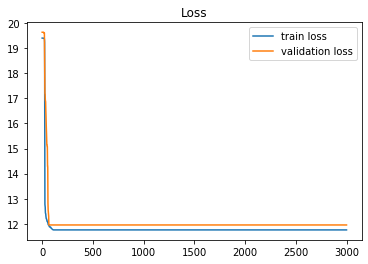

In [73]:
lr = 1e-3
epochs = 3000
batch_size = 120000

model = Model(inputs=input_cols, outputs=[y])
model.compile(loss="mse", optimizer=RMSprop(lr=lr), metrics=[tf.keras.metrics.AUC()])

model.save_weights(checkpoint_path)

history = model.fit([encoded_userID, encoded_users_mean_rating, 
                             encoded_user_reviewcount, encoded_locationId, 
                             encoded_createdDate, encoded_photonum,
                             encoded_rated_count,encoded_average_photonum, 
                             encoded_average_rating], global_df['rating'], 
          batch_size=batch_size, epochs=epochs, validation_split=0.005,
                   callbacks = [cb_checkpoint1, cb_checkpoint2])


plt.plot(history.history["loss"], label="train loss")
plt.plot(history.history["val_loss"], label="validation loss")
plt.legend() 
plt.title("Loss")
plt.show()

In [74]:
# # 모델 불러오기 
# from keras.models import model_from_json 

# json_file = open(os.path.join(model_save_path ," .json"), "r") 
# loaded_model_json = json_file.read() 
# json_file.close() 

# loaded_model = model_from_json(loaded_model_json, # custom_objects={'tf': tf, 'n_factors':8})

# loaded_model.load_weights(os.path.join(model_save_path," .h5"))
# print("Loaded model from disk")

# 유사도 아이템

In [75]:
def latent_to_vec(feature, model, location_df, h_size, input_features):
    layer_name = feature
    intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.get_layer(layer_name).output)
    test = input_features
                             
    locationId_latent_vector = intermediate_layer_model.predict(test)
    
    locationId_latent_vector = locationId_latent_vector.T.reshape(-1, h_size)
    vec = pd.DataFrame(locationId_latent_vector)
    location_df = location_df.reset_index()
    vec['locationId'] = location_df['locationId']
    
    # 아이템별 의미 벡터 생성 
    vec = vec.groupby('locationId').agg([('0','mean')]).reset_index()

    vec = pd.DataFrame(vec.iloc[:,1:].values)
    vec['locationId'] = location_df['locationId'].unique()
    vec = vec.set_index('locationId')
    return vec

In [77]:
vec = latent_to_vec('FM_locationId', model, global_df, 8, [encoded_userID, encoded_users_mean_rating, 
                             encoded_user_reviewcount, encoded_locationId, 
                             encoded_createdDate, encoded_photonum,
                        encoded_rated_count,
                                  encoded_average_photonum, encoded_average_rating])
vec

,0,1,2,3,4,5,6,7
locationId,,,,,,,,
1500428988,12925.578125,12926.226562,12926.880859,12927.535156,12928.183594,12928.837891,12929.486328,12930.134766
1475741466,-7596.900391,-7597.187012,-7597.474121,-7597.761230,-7598.047852,-7598.334961,-7598.622070,-7598.909180
33880173,4748.146973,4748.224121,4748.300781,4748.377930,4748.455078,4748.532227,4748.609375,4748.686035
1517144962,4862.437500,4862.514648,4862.591797,4862.668457,4862.745605,4862.822754,4862.899902,4862.976562
1569821908,4758.621094,4758.698242,4758.774902,4758.852051,4758.929199,4759.006348,4759.083008,4759.160156
...,...,...,...,...,...,...,...,...
7033805,-34974.066406,-34974.953125,-34975.835938,-34976.722656,-34977.605469,-34978.492188,-34979.375000,-34980.261719
6643598,-28469.164062,-28470.048828,-28470.933594,-28471.818359,-28472.703125,-28473.587891,-28474.472656,-28475.357422
8769938,-28408.998047,-28409.882812,-28410.767578,-28411.652344,-28412.537109,-28413.421875,-28414.306641,-28415.191406


In [78]:
vec.to_csv(os.path.join("..","realtime_model",'deepFM_global_vec.csv'))#, index=False)


In [79]:
from numpy import dot
from numpy.linalg import norm
import numpy as np


def cosim_id(df, vec, item_id):
    def cos_sim(A, B):
           return dot(A, B)/(norm(A)*norm(B)) 
    new_vec = vec.copy() 
    sim = []
    
    # 인풋 호텔 정보 데이터에 없는 경우 종료 
    if item_id not in vec.index.tolist():
        return 
        
    for i in range(len(vec)):
        sim.append(cos_sim(vec.loc[item_id,:], vec.iloc[i,:]))

    new_vec['sim'] = sim
    # sim 높은 순 
    new_vec = new_vec['sim'].reset_index().sort_values('sim', ascending=False)
    sim_sorted = new_vec['locationId'].tolist()
    # 인풋 호텔정보 빼고 유사도 높은 순대로 id 
    if item_id in sim_sorted:
        sim_sorted.remove(item_id) 
    return sim_sorted 

In [80]:
import random

def sim_item(vec, df, item_id, top):
    top_id = cosim_id(df, vec, item_id)
    
    if type(top_id) == list :
        df = df.drop_duplicates(['locationId'], keep='last')
        recommend_rst = []
        for x in top_id:
            if df.loc[df['locationId']==x].category.values[0]== 'EAT':
                recommend_rst.append([df.loc[df['locationId']==x][['place.name', 'land.addr']]])

        print('input hotel:', local_df.loc[local_df['locationId']==item_id]['place.name'].unique()[0])
        print('-'*10)
        for i in range(len(recommend_rst[:top])):
            print('top', i+1, recommend_rst[i][0]['place.name'].values[0])
            print('  주소', recommend_rst[i][0]['land.addr'].values[0])
        
    else:
        answer_lst = ['해당 호텔 정보가 없습니다. 다른 호텔을 입력해주세요.', '해당 호텔 정보가 없습니다. 다른 호텔을 추천받아보세요.']
        x = random.randint(0, len(answer_lst)-1)
        return answer_lst[x]
    

데이터 업뎃 후

In [81]:
import random

for location_id in common_acm_ids[:10]:
    print(sim_item(vec, global_df, location_id, 10))
    print()
    print()
    print()
    print('-'*50)

input hotel: 호텔에잇아워즈
----------
top 1 뚝심한우
  주소 서울특별시 중구 명동2가 2-9
top 2 남대문 참숯화로 숯불구이
  주소 서울특별시 중구 남창동 1-1 good&good상동교회
top 3 정통삼계탕
  주소 서울특별시 종로구 수송동 129-1
top 4 피트 카페
  주소 서울특별시 구로구 신도림동 692 디큐브시티
top 5 채근담
  주소 서울특별시 강남구 대치동 983 태범빌딩
top 6 마복림할머니막내아들네
  주소 서울특별시 중구 신당동 233-93 새마을금고회관
top 7 콩예원
  주소 서울특별시 광진구 광장동 102
top 8 파이어벨 버거
  주소 서울특별시 강남구 대치동 908-17
top 9 소문난감자탕
  주소 서울특별시 성동구 성수동2가 315-100
top 10 카페 카푸치노
  주소 서울특별시 강남구 논현동 206-1 호텔 카푸치노
None



--------------------------------------------------
input hotel: 노보텔스위트앰배서더서울용산
----------
top 1 커피愛
  주소 서울특별시 중구 명동2가 27-1
top 2 동경우동
  주소 서울특별시 중구 충무로3가 24-12
top 3 사과나무
  주소 서울특별시 종로구 관훈동 84-5
top 4 신의주부대찌개
  주소 서울특별시 중구 북창동 14-5
top 5 스시히로바
  주소 서울특별시 중구 소공동 1 롯데백화점 본점
top 6 부산양곱창
  주소 서울특별시 강남구 역삼동 700-15
top 7 원조나주곰탕
  주소 서울특별시 강서구 방화동 559-1
top 8 필동면옥
  주소 서울특별시 중구 필동3가 1-5
top 9 베키아에누보 - 본점(신관4층)
  주소 서울특별시 중구 충무로1가 52-5 신세계백화점건물
top 10 성북동 누룽지백숙
  주소 서울특별시 성북구 성북동 281-1
None



-----------------------------------------

In [82]:
import random

for location_id in common_acm_ids[10:20]:
    print(sim_item(vec, global_df, location_id, 10))
    print()
    print()
    print()
    print('-'*50)

input hotel: 롯데시티호텔 마포
----------
top 1 살롱순라
  주소 서울특별시 종로구 권농동 187-7
top 2 전주전집
  주소 서울특별시 동작구 사당동 1032-1
top 3 죠티인도레스토랑
  주소 서울특별시 종로구 관철동 16-1 시사일본어학원
top 4 서교가든
  주소 서울특별시 마포구 서교동 466-1
top 5 켄로쿠우동
  주소 서울특별시 중구 충무로1가 22-13
top 6 홍두깨손칼국수
  주소 서울특별시 마포구 망원동 414-26
top 7 수연 산방
  주소 서울특별시 성북구 성북동 248 상허 이태준 가옥
top 8 화포식당
  주소 서울특별시 영등포구 영등포동3가 3-4 대흥빌딩
top 9 파로그랜드
  주소 서울특별시 중구 수하동 67 미래에셋 센터원(Mirae Asset CENTER1)
top 10 오가와
  주소 서울특별시 종로구 당주동 5 로얄빌딩
None



--------------------------------------------------
input hotel: 레스케이프 호텔
----------
top 1 엔제리너스
  주소 서울특별시 중구 소공동 1 롯데백화점 본점
top 2 멘야산다이메
  주소 서울특별시 양천구 목동 917-9 현대41타워
top 3 명동할머니국수
  주소 서울특별시 종로구 관철동 37-2
top 4 스시시로
  주소 서울특별시 마포구 서교동 408-25
top 5 츄리 츄리
  주소 서울특별시 마포구 상수동 314-3
top 6 던킨 도너츠 서울스퀘어
  주소 서울특별시 중구 남대문로5가 541-1
top 7 하루연가
  주소 서울특별시 종로구 종로6가 103 야드인빌딩
top 8 전주콩나물국밥
  주소 서울특별시 동대문구 휘경동 191-5
top 9 앨리스 청담
  주소 서울특별시 강남구 청담동 84-20
top 10 비바폴로 열매점
  주소 서울특별시 강동구 명일동 312-86
None



------------------------------

In [83]:
import random

for location_id in common_acm_ids[20:30]:
    print(sim_item(vec, global_df, location_id, 10))
    print()
    print()
    print()
    print('-'*50)

input hotel: 강남아르누보시티
----------
top 1 루브리카
  주소 서울특별시 중구 소공동 87-1 서울 웨스틴조선호텔
top 2 델리카한스
  주소 서울특별시 중구 소공동 1 롯데호텔
top 3 스시시로
  주소 서울특별시 마포구 서교동 408-25
top 4 김돈이
  주소 서울특별시 강남구 삼성동 140-29
top 5 라 플랑끄
  주소 서울특별시 용산구 이태원동 129-9
top 6 동원집
  주소 error
top 7 아시안 라이브
  주소 error
top 8 토마틸로
  주소 서울특별시 강남구 역삼동 737 강남파이낸스센터
top 9 포엠
  주소 서울특별시 중구 명동2가 54-7
top 10 학림
  주소 서울특별시 종로구 명륜4가 94-2
None



--------------------------------------------------
input hotel: TheK호텔 서울
----------
top 1 슈치쿠
  주소 서울특별시 영등포구 여의도동 60 63한화생명빌딩
top 2 명동 피자
  주소 서울특별시 중구 충무로1가 22-2
top 3 타볼로 24
  주소 서울특별시 종로구 종로6가 289-3
top 4 바81
  주소 서울특별시 송파구 신천동 29 롯데월드타워앤드롯데월드몰
top 5 더그리핀바
  주소 서울특별시 종로구 종로6가 289-3
top 6 스테이, 모던 레스토랑
  주소 서울특별시 송파구 신천동 29 롯데월드타워앤드롯데월드몰
top 7 다이닝인스페이스
  주소 서울특별시 종로구 원서동 219
top 8 미당순두부
  주소 서울특별시 종로구 관철동 27-1 대진빌딩
top 9 지화자
  주소 서울특별시 종로구 청운동 48
top 10 명동 고양이다락방
  주소 서울특별시 중구 명동2가 51-14
None



--------------------------------------------------
input hotel: 롯데시티호텔 구로
----------
top 1 애류헌
  주소 error

In [84]:
import random

for location_id in common_acm_ids[30:40]:
    print(sim_item(vec, global_df, location_id, 10))
    print()
    print()
    print()
    print('-'*50)

해당 호텔 정보가 없습니다. 다른 호텔을 입력해주세요.



--------------------------------------------------
input hotel: 글래드 여의도
----------
top 1 명동부대찌개
  주소 서울특별시 중구 명동1가 54-7
top 2 벽제 갈비
  주소 서울특별시 서대문구 창천동 13-20
top 3 강촌쌈밥
  주소 서울특별시 종로구 평창동 460-1
top 4 루블랑
  주소 서울특별시 마포구 서교동 342-2
top 5 빅세일
  주소 서울특별시 영등포구 여의도동 54-2 진주상가
top 6 마포만두
  주소 서울특별시 마포구 서교동 393-1
top 7 필동면옥
  주소 서울특별시 중구 필동3가 1-5
top 8 제주돈사돈
  주소 서울특별시 마포구 합정동 426-5
top 9 마지
  주소 서울특별시 종로구 체부동 132-1
top 10 카페코수이
  주소 서울특별시 종로구 통인동 137-1
None



--------------------------------------------------
input hotel: 더스테이트 선유 호텔
----------
top 1 무라
  주소 서울특별시 마포구 서교동 401-15
top 2 GINY
  주소 서울특별시 강남구 논현동 63-20
top 3 던킨 도너츠 서울스퀘어
  주소 서울특별시 중구 남대문로5가 541-1
top 4 민스키친
  주소 서울특별시 강남구 신사동 651-4
top 5 명동정
  주소 서울특별시 중구 충무로2가 60-3 성창빌딩
top 6 포엠
  주소 서울특별시 중구 명동2가 54-7
top 7 마누테라스
  주소 서울특별시 강남구 청담동 90-20
top 8 육대장
  주소 서울특별시 중구 충무로1가 25-5 고려대연각타워
top 9 츄리 츄리
  주소 서울특별시 마포구 상수동 314-3
top 10 스시시로
  주소 서울특별시 마포구 서교동 408-25
None



---------------------------------

In [85]:
import random

for location_id in common_acm_ids[40:50]:
    print(sim_item(vec, global_df, location_id, 10))
    print()
    print()
    print()
    print('-'*50)

input hotel: 골든서울호텔
----------
top 1 멘야산다이메
  주소 서울특별시 양천구 목동 917-9 현대41타워
top 2 화포식당
  주소 서울특별시 영등포구 영등포동3가 3-4 대흥빌딩
top 3 토다이
  주소 서울특별시 강남구 대치동 1005-5
top 4 쿄베이커리
  주소 서울특별시 마포구 상수동 317-4 상수동 오피스텔
top 5 Uncle's Grilled Fish
  주소 서울특별시 중구 남창동 168-2
top 6 안동찜닭
  주소 error
top 7 꾸잉
  주소 서울특별시 용산구 이태원동 123-33
top 8 체부동수제비와보리밥
  주소 서울특별시 종로구 체부동 88-1
top 9 피자 필
  주소 서울특별시 종로구 관철동 43-9
top 10 소녀방앗간
  주소 서울특별시 성동구 성수동1가 668-35
None



--------------------------------------------------
input hotel: 나인트리프리미어호텔 명동2
----------
top 1 다모토리
  주소 서울특별시 용산구 용산동2가 44-18
top 2 빠꼬로꼬
  주소 서울특별시 용산구 이태원동 713
top 3 보칼리노
  주소 error
top 4 붓처스컷
  주소 서울특별시 용산구 한남동 738-23
top 5 홍연
  주소 서울특별시 중구 소공동 87-1 서울 웨스틴조선호텔
top 6 BLT 스테이크
  주소 서울특별시 종로구 종로6가 289-3
top 7 지화자
  주소 서울특별시 종로구 청운동 48
top 8 10꼬르소꼬모카페
  주소 서울특별시 강남구 청담동 79
top 9 인굿컴퍼니
  주소 서울특별시 강남구 신사동 554-3
top 10 미당순두부
  주소 서울특별시 종로구 관철동 27-1 대진빌딩
None



--------------------------------------------------
input hotel: 노보텔 앰배서더 서울 강남
----------
top 1 패스트리부티크

In [86]:
import random

for location_id in common_acm_ids[50:60]:
    print(sim_item(vec, global_df, location_id, 10))
    print()
    print()
    print()
    print('-'*50)

input hotel: 라마다호텔앤스위트서울남대문
----------
top 1 쉐라톤그랜드워커힐 더뷔페
  주소 서울특별시 광진구 광장동 22-1 워커힐호텔
top 2 차이797 - 서래마을
  주소 서울특별시 서초구 방배동 810-2
top 3 도깨비불고기
  주소 서울특별시 중구 필동1가 3-1
top 4 마포만두
  주소 서울특별시 마포구 서교동 393-1
top 5 소울 쿠키
  주소 서울특별시 마포구 창전동 2-48
top 6 리틀 사이공
  주소 서울특별시 강서구 방화동 886 김포공항, 롯데몰, 스카이시티
top 7 오설록티하우스
  주소 서울특별시 서초구 서초동 1328 홍우빌딩
top 8 루나아시아
  주소 서울특별시 강남구 삼성동 152-62 명당빌딩
top 9 카페코수이
  주소 서울특별시 종로구 통인동 137-1
top 10 피에르 가니에르 서울
  주소 서울특별시 중구 소공동 1 롯데백화점 본점
None



--------------------------------------------------
input hotel: 베스트웨스턴프리미어서울가든호텔
----------
top 1 일야에스프레소
  주소 서울특별시 마포구 염리동 172-1 일야빌딩
top 2 코벤트가든
  주소 서울특별시 송파구 방이동 171 올림픽베어스타운
top 3 리차드 카피캣
  주소 서울특별시 용산구 한남동 736-9
top 4 필경재
  주소 서울특별시 강남구 수서동 739-1
top 5 GINY
  주소 서울특별시 강남구 논현동 63-20
top 6 서울 베이킹 컴퍼니 - JW 메리어트 동대문 스퀘어 서울
  주소 서울특별시 종로구 종로6가 289-3
top 7 88브레드
  주소 서울특별시 강남구 신사동 566-3
top 8 민스키친
  주소 서울특별시 강남구 신사동 651-4
top 9 호아빈
  주소 서울특별시 중구 을지로2가 199-58
top 10 Kervan Bakery
  주소 서울특별시 용산구 이태원동 126-2
None



--------

In [87]:
import random

for location_id in common_acm_ids[60:70]:
    print(sim_item(vec, global_df, location_id, 10))
    print()
    print()
    print()
    print('-'*50)

input hotel: 강남패밀리호텔
----------
top 1 전주전집
  주소 서울특별시 동작구 사당동 1032-1
top 2 소복
  주소 서울특별시 마포구 서교동 408-7
top 3 다모토리
  주소 서울특별시 용산구 용산동2가 44-18
top 4 빠꼬로꼬
  주소 서울특별시 용산구 이태원동 713
top 5 이요이요스시
  주소 서울특별시 마포구 아현동 772
top 6 쟈니덤플링
  주소 서울특별시 용산구 이태원동 130-3
top 7 홍연
  주소 서울특별시 중구 소공동 87-1 서울 웨스틴조선호텔
top 8 다담
  주소 서울특별시 강남구 청담동 97-1 M빌딩
top 9 스와니예
  주소 서울특별시 서초구 반포동 549-17 스튜디오소
top 10 토속촌삼계탕
  주소 서울특별시 종로구 체부동 85-1 토속촌
None



--------------------------------------------------
input hotel: 아트리움바비엥2
----------
top 1 멘야산다이메
  주소 서울특별시 양천구 목동 917-9 현대41타워
top 2 서울서 둘째로 잘하는 집
  주소 서울특별시 종로구 삼청동 28-21
top 3 쿠이신보
  주소 서울특별시 마포구 합정동 413-16
top 4 골든치즈타르트
  주소 서울특별시 마포구 합정동 472 마포 한강 푸르지오
top 5 광부
  주소 서울특별시 강남구 청담동 22-20
top 6 더 라운지
  주소 서울특별시 종로구 종로6가 289-3
top 7 스즈란테이
  주소 서울특별시 강서구 마곡동 797-14 힐스테이트에코마곡
top 8 차마시는뜰
  주소 서울특별시 종로구 삼청동 35-169
top 9 김가네김밥
  주소 서울특별시 중구 필동1가 35-1
top 10 경성갈비
  주소 서울특별시 강남구 대치동 996-7
None



--------------------------------------------------
input hotel: 오라카이 인사동 스위츠
---

In [88]:
import random

for location_id in common_acm_ids[70:80]:
    print(sim_item(vec, global_df, location_id, 10))
    print()
    print()
    print()
    print('-'*50)

input hotel: 인터시티365
----------
top 1 멘야산다이메
  주소 서울특별시 양천구 목동 917-9 현대41타워
top 2 이요이요스시
  주소 서울특별시 마포구 아현동 772
top 3 슈치쿠
  주소 서울특별시 영등포구 여의도동 60 63한화생명빌딩
top 4 더 스테이크 하우스
  주소 서울특별시 용산구 한남동 747-7 하얏트호텔
top 5 란주라미엔
  주소 서울특별시 중구 충무로1가 25-9
top 6 벽제구이로
  주소 서울특별시 용산구 이촌동 301-154
top 7 도림
  주소 서울특별시 송파구 잠실동 40-1 롯데월드
top 8 오메가삼계탕
  주소 서울특별시 용산구 이촌동 302-64 장미아파트
top 9 빠꼬로꼬
  주소 서울특별시 용산구 이태원동 713
top 10 지화자
  주소 서울특별시 종로구 청운동 48
None



--------------------------------------------------
input hotel: Hotel in 9
----------
top 1 도림
  주소 서울특별시 송파구 잠실동 40-1 롯데월드
top 2 낭만짬뽕
  주소 서울특별시 중구 충무로3가 58-14
top 3 죠티인도레스토랑
  주소 서울특별시 종로구 관철동 16-1 시사일본어학원
top 4 서울리스타 커피&펍
  주소 서울특별시 중구 남대문로5가 84-16 호텔마누
top 5 모찌
  주소 서울특별시 용산구 이태원동 126-7
top 6 핏제리아오
  주소 서울특별시 종로구 동숭동 31-19
top 7 수와래
  주소 서울특별시 종로구 삼청동 35-116
top 8 샤뽀 블랑
  주소 서울특별시 성북구 성북동 161-14
top 9 오보록
  주소 서울특별시 성북구 성북동 133-42
top 10 커피 방앗간
  주소 서울특별시 종로구 화동 102-1
None



--------------------------------------------------
해당 호텔 정보가 없습니다. 다른 호텔을 입력해

In [89]:
import random

for location_id in common_acm_ids[80:90]:
    print(sim_item(vec, global_df, location_id, 10))
    print()
    print()
    print()
    print('-'*50)

input hotel: G2 호텔
----------
top 1 스테이, 모던 레스토랑
  주소 서울특별시 송파구 신천동 29 롯데월드타워앤드롯데월드몰
top 2 서원
  주소 서울특별시 중구 충무로2가 62-8 세룡빌딩
top 3 아키라백 서울
  주소 서울특별시 종로구 당주동 30
top 4 아트리오
  주소 서울특별시 영등포구 여의도동 23-1 서울 국제금융 센터
top 5 라따블
  주소 서울특별시 중구 명동1가 59-5 명동 토투앤,엠버서더호텔
top 6 마우스 래빗 커피
  주소 서울특별시 광진구 화양동 5-14
top 7 슈치쿠
  주소 서울특별시 영등포구 여의도동 60 63한화생명빌딩
top 8 맛찬들왕소금구이
  주소 서울특별시 강서구 마곡동 723
top 9 동원집
  주소 error
top 10 커피한약방
  주소 서울특별시 중구 을지로2가 101-34
None



--------------------------------------------------
input hotel: 서울 렉스 호텔
----------
top 1 지화자
  주소 서울특별시 종로구 청운동 48
top 2 비바폴로 열매점
  주소 서울특별시 강동구 명일동 312-86
top 3 러빈허 플라워카페
  주소 error
top 4 동경스테이크
  주소 서울특별시 노원구 중계동 591 대호프라자
top 5 양국
  주소 서울특별시 강남구 역삼동 643-3
top 6 더그리핀바
  주소 서울특별시 종로구 종로6가 289-3
top 7 권숙수
  주소 서울특별시 강남구 신사동 643-18
top 8 스테이, 모던 레스토랑
  주소 서울특별시 송파구 신천동 29 롯데월드타워앤드롯데월드몰
top 9 다이닝인스페이스
  주소 서울특별시 종로구 원서동 219
top 10 미당순두부
  주소 서울특별시 종로구 관철동 27-1 대진빌딩
None



--------------------------------------------------
input hotel: 라까사

In [90]:
import random

for location_id in common_acm_ids[90:100]:
    print(sim_item(vec, global_df, location_id, 10))
    print()
    print()
    print()
    print('-'*50)

input hotel: 롯데 호텔 서울
----------
top 1 비바폴로 열매점
  주소 서울특별시 강동구 명일동 312-86
top 2 샤뽀 블랑
  주소 서울특별시 성북구 성북동 161-14
top 3 Uncle's Grilled Fish
  주소 서울특별시 중구 남창동 168-2
top 4 안동찜닭
  주소 error
top 5 커피 방앗간
  주소 서울특별시 종로구 화동 102-1
top 6 피자 필
  주소 서울특별시 종로구 관철동 43-9
top 7 일치프리아니
  주소 서울특별시 강남구 신사동 651-16 호림아트센터 2빌딩
top 8 순희네빈대떡
  주소 서울특별시 종로구 예지동 2-1
top 9 종로제면소
  주소 서울특별시 종로구 묘동 156-1
top 10 러빈허 플라워카페
  주소 error
None



--------------------------------------------------
input hotel: 이비스 스타일 앰배서더 서울 명동
----------
top 1 라구뜨
  주소 서울특별시 광진구 자양동 227-342 롯데백화점
top 2 어메이징브루잉컴퍼니
  주소 서울특별시 성동구 성수동1가 27-12
top 3 공릉닭한마리
  주소 서울특별시 서대문구 대현동 104-69 부소빌딩
top 4 웨스트진베이커리
  주소 서울특별시 양천구 목동 908-29 하이베라스
top 5 스즈란테이
  주소 서울특별시 강서구 마곡동 797-14 힐스테이트에코마곡
top 6 슈치쿠
  주소 서울특별시 영등포구 여의도동 60 63한화생명빌딩
top 7 322소월로-카우리
  주소 서울특별시 용산구 한남동 747-7 하얏트호텔
top 8 현초밥
  주소 서울특별시 종로구 명륜4가 166-1 영성빌딩
top 9 리차드 카피캣
  주소 서울특별시 용산구 한남동 736-9
top 10 와플잇업
  주소 서울특별시 서대문구 대현동 27-17
None



--------------------------------------

In [91]:
import random

for location_id in common_acm_ids[100:110]:
    print(sim_item(vec, global_df, location_id, 10))
    print()
    print()
    print()
    print('-'*50)

input hotel: 포시즌스 호텔 서울
----------
top 1 만푸쿠
  주소 서울특별시 송파구 송파동 52-1
top 2 Uncle's Grilled Fish
  주소 서울특별시 중구 남창동 168-2
top 3 안동찜닭
  주소 error
top 4 미가본
  주소 서울특별시 중구 명동2가 2-23
top 5 호아빈
  주소 서울특별시 중구 을지로2가 199-58
top 6 권숙수
  주소 서울특별시 강남구 신사동 643-18
top 7 해우리
  주소 서울특별시 영등포구 여의도동 23 서울 국제금융 센터
top 8 계동빈대떡신사
  주소 서울특별시 종로구 계동 145
top 9 민스키친
  주소 서울특별시 강남구 신사동 651-4
top 10 애류헌
  주소 error
None



--------------------------------------------------
input hotel: 호텔28 명동
----------
top 1 베제투스
  주소 서울특별시 용산구 용산동2가 22-12
top 2 아오이토리
  주소 서울특별시 마포구 서교동 327-17 K.C빌딩
top 3 소녀방앗간
  주소 서울특별시 성동구 성수동1가 668-35
top 4 팔덕식당
  주소 서울특별시 서대문구 창천동 72-31
top 5 봉래헌
  주소 서울특별시 강서구 외발산동 426 메이필드호텔
top 6 던킨 도너츠 서울스퀘어
  주소 서울특별시 중구 남대문로5가 541-1
top 7 Momoyama
  주소 error
top 8 낭만짬뽕
  주소 서울특별시 중구 충무로3가 58-14
top 9 Uncle's Grilled Fish
  주소 서울특별시 중구 남창동 168-2
top 10 이요이요스시
  주소 서울특별시 마포구 아현동 772
None



--------------------------------------------------
input hotel: 더 그랜드 호텔 명동
----------
top 1 카페큐브 한옥카페
  주소 서울특별시 중구

In [92]:
import random

for location_id in common_acm_ids[110:120]:
    print(sim_item(vec, global_df, location_id, 10))
    print()
    print()
    print()
    print('-'*50)

input hotel: 호텔 스카이파크 센트럴 명동
----------
top 1 안동찜닭
  주소 error
top 2 멘야산다이메
  주소 서울특별시 양천구 목동 917-9 현대41타워
top 3 스와니예
  주소 서울특별시 서초구 반포동 549-17 스튜디오소
top 4 소복
  주소 서울특별시 마포구 서교동 408-7
top 5 다모토리
  주소 서울특별시 용산구 용산동2가 44-18
top 6 빠꼬로꼬
  주소 서울특별시 용산구 이태원동 713
top 7 쟈니덤플링
  주소 서울특별시 용산구 이태원동 130-3
top 8 토속촌삼계탕
  주소 서울특별시 종로구 체부동 85-1 토속촌
top 9 지화자
  주소 서울특별시 종로구 청운동 48
top 10 이요이요스시
  주소 서울특별시 마포구 아현동 772
None



--------------------------------------------------
input hotel: 이코노미 호텔 명동 프리미어
----------
top 1 셰프스 노트
  주소 서울특별시 강남구 삼성동 159 호텔오크우드프리미어
top 2 오메가삼계탕
  주소 서울특별시 용산구 이촌동 302-64 장미아파트
top 3 커피한약방
  주소 서울특별시 중구 을지로2가 101-34
top 4 TAJ
  주소 서울특별시 중구 명동1가 1-3 YWCA연합회
top 5 던킨 도너츠 서울역1호
  주소 error
top 6 더김치찌개
  주소 서울특별시 광진구 구의동 246-3
top 7 화포식당
  주소 서울특별시 영등포구 영등포동3가 3-4 대흥빌딩
top 8 개미집1
  주소 서울특별시 광진구 화양동 508-2
top 9 해우리
  주소 서울특별시 영등포구 여의도동 23 서울 국제금융 센터
top 10 켄로쿠우동
  주소 서울특별시 중구 충무로1가 22-13
None



--------------------------------------------------
input hotel: 까사 명동 게스트하우스
----------

In [93]:
import random

for location_id in common_acm_ids[120:130]:
    print(sim_item(vec, global_df, location_id, 10))
    print()
    print()
    print()
    print('-'*50)

input hotel: 을지로 코업레지던스
----------
top 1 카페 연남동 239-20
  주소 서울특별시 마포구 연남동 239-20
top 2 하나우동
  주소 서울특별시 강남구 신사동 578-5
top 3 88브레드
  주소 서울특별시 강남구 신사동 566-3
top 4 화포식당
  주소 서울특별시 영등포구 영등포동3가 3-4 대흥빌딩
top 5 민스키친
  주소 서울특별시 강남구 신사동 651-4
top 6 호아빈
  주소 서울특별시 중구 을지로2가 199-58
top 7 커피한약방
  주소 서울특별시 중구 을지로2가 101-34
top 8 맛찬들왕소금구이
  주소 서울특별시 강서구 마곡동 723
top 9 그레인
  주소 서울특별시 마포구 연남동 385-6
top 10 더 라운지, 파크 하얏트 서울
  주소 error
None



--------------------------------------------------
input hotel: 사보이호텔
----------
top 1 마포만두
  주소 서울특별시 마포구 서교동 393-1
top 2 조계사 키친 승소
  주소 서울특별시 종로구 수송동 46-10 삼오모텔
top 3 카페코수이
  주소 서울특별시 종로구 통인동 137-1
top 4 루블랑
  주소 서울특별시 마포구 서교동 342-2
top 5 서래갈매기
  주소 서울특별시 동대문구 휘경동 191-5
top 6 론드리프로젝트
  주소 서울특별시 용산구 용산동2가 15-13
top 7 노아
  주소 서울특별시 용산구 용산2가동 46-5 Sunny Hill
top 8 리틀 사이공
  주소 서울특별시 강서구 방화동 886 김포공항, 롯데몰, 스카이시티
top 9 로코스 BBQ
  주소 서울특별시 용산구 이태원동 2-5
top 10 투스카니
  주소 서울특별시 중구 태평로2가 23 더 플라자
None



--------------------------------------------------
input hotel: 시어소 호텔
----

In [94]:
import random

for location_id in common_acm_ids[130:140]:
    print(sim_item(vec, global_df, location_id, 10))
    print()
    print()
    print()
    print('-'*50)

input hotel: 트레블로지 명동 을지로호텔
----------
top 1 현대칼국수
  주소 서울특별시 중구 태평로2가 69-3 청남빌딩
top 2 커피 방앗간
  주소 서울특별시 종로구 화동 102-1
top 3 미성옥
  주소 서울특별시 중구 명동1가 54-6
top 4 닐반아
  주소 서울특별시 종로구 관훈동 120
top 5 청수정
  주소 서울특별시 종로구 삼청동 80-6
top 6 이드 - 할랄 코리안 푸드
  주소 서울특별시 용산구 한남동 756-10
top 7 카페 두루
  주소 서울특별시 종로구 가회동 64-1
top 8 경천애인2237
  주소 서울특별시 강남구 삼성동 142-46 암천빌딩
top 9 부빙
  주소 서울특별시 종로구 부암동 254-2
top 10 프라그로 다이너
  주소 서울특별시 용산구 한강로2가 148-7
None



--------------------------------------------------
input hotel: 호텔 스카이파크 명동 1
----------
top 1 코요테살룬
  주소 서울특별시 중구 남대문로5가 526 대우재단빌딩
top 2 산울림
  주소 서울특별시 마포구 창전동 5-138
top 3 카페큐브 한옥카페
  주소 서울특별시 중구 남대문로4가 71-1
top 4 트라토리아 몰토
  주소 서울특별시 마포구 상암동 34-36 안언하우스
top 5 츄리 츄리
  주소 서울특별시 마포구 상수동 314-3
top 6 켄로쿠우동
  주소 서울특별시 중구 충무로1가 22-13
top 7 커피한약방
  주소 서울특별시 중구 을지로2가 101-34
top 8 하코네
  주소 서울특별시 강남구 삼성동 159-8 파르나스타워
top 9 빠꼬로꼬
  주소 서울특별시 용산구 이태원동 713
top 10 소녀방앗간
  주소 서울특별시 성동구 성수동1가 668-35
None



--------------------------------------------------
input hotel: 라마다 서

In [95]:
import random

for location_id in common_acm_ids[140:150]:
    print(sim_item(vec, global_df, location_id, 10))
    print()
    print()
    print()
    print('-'*50)

input hotel: 호텔 통 서울 명동
----------
top 1 원조원할매소문난닭한마리
  주소 서울특별시 종로구 종로5가 282-21
top 2 아트리오
  주소 서울특별시 영등포구 여의도동 23-1 서울 국제금융 센터
top 3 물뛴다
  주소 서울특별시 서대문구 충정로3가 3-12
top 4 수제만두 국시각시
  주소 error
top 5 비바폴로 열매점
  주소 서울특별시 강동구 명일동 312-86
top 6 현초밥
  주소 서울특별시 종로구 명륜4가 166-1 영성빌딩
top 7 알천생태찌개
  주소 서울특별시 송파구 잠실동 197-7 sms
top 8 소녀방앗간
  주소 서울특별시 성동구 성수동1가 668-35
top 9 Parmi Italiano
  주소 error
top 10 교토마블
  주소 서울특별시 용산구 용산동5가 24-1 파크타워아파트
None



--------------------------------------------------
input hotel: 호텔 마누
----------
top 1 전주전집
  주소 서울특별시 동작구 사당동 1032-1
top 2 던킨 도너츠 서울스퀘어
  주소 서울특별시 중구 남대문로5가 541-1
top 3 소녀방앗간
  주소 서울특별시 성동구 성수동1가 668-35
top 4 스시시로
  주소 서울특별시 마포구 서교동 408-25
top 5 팜티진 쌀국수
  주소 서울특별시 성동구 도선동 69 성동삼성쉐르빌
top 6 도림
  주소 서울특별시 송파구 잠실동 40-1 롯데월드
top 7 Chakraa Indian Restaurant, Hannam, Seoul
  주소 error
top 8 꾸스꾸스
  주소 서울특별시 종로구 체부동 95-1
top 9 아르모니움
  주소 서울특별시 용산구 한남동 657-37
top 10 청수
  주소 error
None



--------------------------------------------------
input hotel: 

In [96]:
import random

for location_id in common_acm_ids[150:160]:
    print(sim_item(vec, global_df, location_id, 10))
    print()
    print()
    print()
    print('-'*50)

input hotel: 글로리 인
----------
top 1 시크릿가든
  주소 서울특별시 종로구 와룡동 69
top 2 지화자
  주소 서울특별시 종로구 청운동 48
top 3 익선동고기집
  주소 서울특별시 종로구 익선동 160-2
top 4 파파이스
  주소 서울특별시 종로구 연건동 128-8 홍익대학교대학로캠퍼스
top 5 물뛴다
  주소 서울특별시 서대문구 충정로3가 3-12
top 6 타이거타이거
  주소 서울특별시 종로구 권농동 171-6
top 7 다이닝인스페이스
  주소 서울특별시 종로구 원서동 219
top 8 카페 연남동 239-20
  주소 서울특별시 마포구 연남동 239-20
top 9 트렌치타운
  주소 서울특별시 용산구 이태원동 99-14 모뎀빌
top 10 베제투스
  주소 서울특별시 용산구 용산동2가 22-12
None



--------------------------------------------------
input hotel: 크레토 호텔 명동
----------
top 1 하루연가
  주소 서울특별시 종로구 종로6가 103 야드인빌딩
top 2 민스키친
  주소 서울특별시 강남구 신사동 651-4
top 3 Momoyama
  주소 error
top 4 봉래헌
  주소 서울특별시 강서구 외발산동 426 메이필드호텔
top 5 Uncle's Grilled Fish
  주소 서울특별시 중구 남창동 168-2
top 6 제이히든하우스
  주소 서울특별시 종로구 종로6가 94
top 7 이춘복참치
  주소 서울특별시 용산구 남영동 85-1
top 8 죠티인도레스토랑
  주소 서울특별시 종로구 관철동 16-1 시사일본어학원
top 9 갓덴스시
  주소 서울특별시 종로구 관철동 19-1 해덕빌딩
top 10 르스타일
  주소 서울특별시 중구 충무로2가 53-10
None



--------------------------------------------------
input hotel: 호텔 봉봉
----------
top

In [97]:
import random

for location_id in common_acm_ids[160:170]:
    print(sim_item(vec, global_df, location_id, 10))
    print()
    print()
    print()
    print('-'*50)

input hotel: 뉴 오리엔탈 호텔
----------
top 1 전주전집
  주소 서울특별시 동작구 사당동 1032-1
top 2 츄리 츄리
  주소 서울특별시 마포구 상수동 314-3
top 3 티 테라피
  주소 서울특별시 종로구 안국동 6-1
top 4 한우리 한정식
  주소 서울특별시 강남구 논현동 91-4 코오라빌딩
top 5 서브웨이
  주소 서울특별시 중구 필동2가 16-13
top 6 쌈사랑
  주소 서울특별시 중구 충무로4가 132-5
top 7 슌미
  주소 서울특별시 강남구 역삼동 603 노보텔 앰배서더 강남 서울
top 8 월향
  주소 서울특별시 중구 태평로1가 61-27 조선일보사건물
top 9 물뛴다
  주소 서울특별시 서대문구 충정로3가 3-12
top 10 진상샤브샤브
  주소 서울특별시 강남구 청담동 87-1 담빌딩
None



--------------------------------------------------
input hotel: 토모 레지던스
----------
top 1 스즈란테이
  주소 서울특별시 강서구 마곡동 797-14 힐스테이트에코마곡
top 2 도림
  주소 서울특별시 송파구 잠실동 40-1 롯데월드
top 3 멘야산다이메
  주소 서울특별시 양천구 목동 917-9 현대41타워
top 4 죠티인도레스토랑
  주소 서울특별시 종로구 관철동 16-1 시사일본어학원
top 5 켄로쿠우동
  주소 서울특별시 중구 충무로1가 22-13
top 6 레드스모크 바비큐
  주소 서울특별시 종로구 관철동 12-23
top 7 더 버뮤다
  주소 서울특별시 용산구 이태원동 34-50
top 8 개미집1
  주소 서울특별시 광진구 화양동 508-2
top 9 이춘복참치
  주소 서울특별시 용산구 남영동 85-1
top 10 미스터램
  주소 서울특별시 강남구 삼성동 166-5 홍선빌딩
None



--------------------------------------------------
input hotel: 에

In [98]:
import random

for location_id in common_acm_ids[170:180]:
    print(sim_item(vec, global_df, location_id, 10))
    print()
    print()
    print()
    print('-'*50)

input hotel: 글래드 라이브 강남
----------
top 1 전주전집
  주소 서울특별시 동작구 사당동 1032-1
top 2 정통삼계탕
  주소 서울특별시 종로구 수송동 129-1
top 3 가메골손만두
  주소 서울특별시 중구 남창동 60-2
top 4 VIPS
  주소 서울특별시 종로구 혜화동 90-18 혜화동씨티밸리
top 5 김가네김밥
  주소 서울특별시 중구 충무로1가 25-45
top 6 혜화칼국수
  주소 서울특별시 종로구 혜화동 84-3
top 7 콩예원
  주소 서울특별시 광진구 광장동 102
top 8 송림식당
  주소 서울특별시 광진구 자양동 227-136
top 9 화목순대국
  주소 서울특별시 영등포구 여의도동 44-14 경도빌딩
top 10 메가씨씨
  주소 서울특별시 송파구 잠실동 40-1 롯데월드
None



--------------------------------------------------
input hotel: 로얄 호텔 서울
----------
top 1 인도로가는길 레스토랑
  주소 서울특별시 종로구 관훈동 198-36 오원빌딩
top 2 라세느
  주소 서울특별시 송파구 잠실동 40-1 롯데월드
top 3 명월관
  주소 서울특별시 광진구 광장동 22-1 워커힐호텔
top 4 이요이요스시
  주소 서울특별시 마포구 아현동 772
top 5 스와니예
  주소 서울특별시 서초구 반포동 549-17 스튜디오소
top 6 10꼬르소꼬모카페
  주소 서울특별시 강남구 청담동 79
top 7 다모토리
  주소 서울특별시 용산구 용산동2가 44-18
top 8 마피아디저트
  주소 서울특별시 용산구 이태원동 451-7
top 9 오메가삼계탕
  주소 서울특별시 용산구 이촌동 302-64 장미아파트
top 10 헴라갓
  주소 서울특별시 중구 회현동1가 208 남산 롯데캐슬
None



--------------------------------------------------
input hotel: 

In [99]:
import random

for location_id in common_acm_ids[180:190]:
    print(sim_item(vec, global_df, location_id, 10))
    print()
    print()
    print()
    print('-'*50)

input hotel: 호텔 더 디자이너스 홍대
----------
top 1 비사벌전주콩나물국밥
  주소 서울특별시 성동구 성수동1가 661-2
top 2 샤뽀 블랑
  주소 서울특별시 성북구 성북동 161-14
top 3 투브로즈
  주소 서울특별시 용산구 한남동 736-8
top 4 커피 방앗간
  주소 서울특별시 종로구 화동 102-1
top 5 비스떼까
  주소 서울특별시 용산구 이태원동 211-33
top 6 진미육가
  주소 서울특별시 동대문구 장안동 433-3
top 7 드렁큰콰이즈
  주소 서울특별시 중구 충무로2가 53-9
top 8 카페 카푸치노
  주소 서울특별시 강남구 논현동 206-1 호텔 카푸치노
top 9 소문난감자탕
  주소 서울특별시 성동구 성수동2가 315-100
top 10 파이어벨 버거
  주소 서울특별시 강남구 대치동 908-17
None



--------------------------------------------------
input hotel: 센터마크 호텔
----------
top 1 빠꼬로꼬
  주소 서울특별시 용산구 이태원동 713
top 2 카페큐브 한옥카페
  주소 서울특별시 중구 남대문로4가 71-1
top 3 전주전집
  주소 서울특별시 동작구 사당동 1032-1
top 4 카페 연남동 239-20
  주소 서울특별시 마포구 연남동 239-20
top 5 만선호프
  주소 서울특별시 중구 을지로3가 95-2
top 6 광화문양갈비
  주소 서울특별시 중구 태평로1가 62-7 광안빌딩
top 7 월향
  주소 서울특별시 중구 태평로1가 61-27 조선일보사건물
top 8 물뛴다
  주소 서울특별시 서대문구 충정로3가 3-12
top 9 뽀모도로
  주소 서울특별시 종로구 관철동 45-1 대왕빌딩
top 10 Myeongdong Gyoja Cheongdaemun
  주소 error
None



--------------------------------------------------
i

In [100]:
import random

for location_id in common_acm_ids[190:200]:
    print(sim_item(vec, global_df, location_id, 10))
    print()
    print()
    print()
    print('-'*50)

input hotel: 메트로 호텔
----------
top 1 멘야산다이메
  주소 서울특별시 양천구 목동 917-9 현대41타워
top 2 고려삼계탕
  주소 서울특별시 종로구 세종로 164
top 3 애류헌
  주소 error
top 4 코코브루니
  주소 서울특별시 강남구 신사동 536-18
top 5 한국맥주거래소
  주소 서울특별시 영등포구 여의도동 44-35 제일빌딩
top 6 롤인익선
  주소 서울특별시 종로구 익선동 93
top 7 던킨 도너츠 서울스퀘어
  주소 서울특별시 중구 남대문로5가 541-1
top 8 더그리핀바
  주소 서울특별시 종로구 종로6가 289-3
top 9 주옥
  주소 서울특별시 중구 태평로2가 23 더 플라자
top 10 시그니엘 서울 더 라운지
  주소 서울특별시 송파구 신천동 29 롯데월드타워앤드롯데월드몰
None



--------------------------------------------------
input hotel: JW 메리어트 호텔 서울
----------
top 1 던킨 도너츠 서울스퀘어
  주소 서울특별시 중구 남대문로5가 541-1
top 2 지화자
  주소 서울특별시 종로구 청운동 48
top 3 미당순두부
  주소 서울특별시 종로구 관철동 27-1 대진빌딩
top 4 비바폴로 열매점
  주소 서울특별시 강동구 명일동 312-86
top 5 류니끄
  주소 서울특별시 강남구 신사동 520-1
top 6 반반국수
  주소 서울특별시 중구 필동1가 24-8
top 7 수와래
  주소 서울특별시 종로구 삼청동 35-116
top 8 쿠이신보
  주소 서울특별시 마포구 합정동 413-16
top 9 소녀방앗간
  주소 서울특별시 성동구 성수동1가 668-35
top 10 Uncle's Grilled Fish
  주소 서울특별시 중구 남창동 168-2
None



--------------------------------------------------
input hotel:

In [101]:
import random

for location_id in common_acm_ids[200:210]:
    print(sim_item(vec, global_df, location_id, 10))
    print()
    print()
    print()
    print('-'*50)

input hotel: 호텔 아트리움
----------
top 1 수제만두 국시각시
  주소 error
top 2 더그리핀바
  주소 서울특별시 종로구 종로6가 289-3
top 3 아오이토리
  주소 서울특별시 마포구 서교동 327-17 K.C빌딩
top 4 익선동고기집
  주소 서울특별시 종로구 익선동 160-2
top 5 계림식당
  주소 서울특별시 종로구 종로3가 167
top 6 서울리스타 커피&펍
  주소 서울특별시 중구 남대문로5가 84-16 호텔마누
top 7 VIPS
  주소 서울특별시 종로구 혜화동 90-18 혜화동씨티밸리
top 8 주옥
  주소 서울특별시 중구 태평로2가 23 더 플라자
top 9 빚짜
  주소 서울특별시 종로구 내자동 19 사학회관
top 10 꾸잉
  주소 서울특별시 용산구 이태원동 123-33
None



--------------------------------------------------
input hotel: 호텔 스카이파크 동대문 I
----------
top 1 이삭토스트
  주소 서울특별시 마포구 성산동 244-6
top 2 러빈허 플라워카페
  주소 error
top 3 바81
  주소 서울특별시 송파구 신천동 29 롯데월드타워앤드롯데월드몰
top 4 주옥
  주소 서울특별시 중구 태평로2가 23 더 플라자
top 5 더그리핀바
  주소 서울특별시 종로구 종로6가 289-3
top 6 정식당
  주소 서울특별시 강남구 청담동 83-24
top 7 비바폴로 열매점
  주소 서울특별시 강동구 명일동 312-86
top 8 명동 피자
  주소 서울특별시 중구 충무로1가 22-2
top 9 양국
  주소 서울특별시 강남구 역삼동 643-3
top 10 멘야산다이메
  주소 서울특별시 양천구 목동 917-9 현대41타워
None



--------------------------------------------------
input hotel: 선샤인 호텔
----------
top 1 

In [102]:
import random

for location_id in common_acm_ids[210:220]:
    print(sim_item(vec, global_df, location_id, 10))
    print()
    print()
    print()
    print('-'*50)

input hotel: 알로프트 서울 강남
----------
top 1 GINY
  주소 서울특별시 강남구 논현동 63-20
top 2 패스트리부티크
  주소 서울특별시 중구 장충동2가 202 신라호텔
top 3 스시시로
  주소 서울특별시 마포구 서교동 408-25
top 4 도림
  주소 서울특별시 송파구 잠실동 40-1 롯데월드
top 5 Uncle's Grilled Fish
  주소 서울특별시 중구 남창동 168-2
top 6 시그니엘 서울 더 라운지
  주소 서울특별시 송파구 신천동 29 롯데월드타워앤드롯데월드몰
top 7 권숙수
  주소 서울특별시 강남구 신사동 643-18
top 8 주옥
  주소 서울특별시 중구 태평로2가 23 더 플라자
top 9 멘야산다이메
  주소 서울특별시 양천구 목동 917-9 현대41타워
top 10 미당순두부
  주소 서울특별시 종로구 관철동 27-1 대진빌딩
None



--------------------------------------------------
input hotel: 호텔 페이토 강남
----------
top 1 또보겠지
  주소 서울특별시 마포구 서교동 358-68
top 2 엘피노323
  주소 서울특별시 용산구 이태원동 559
top 3 두레유
  주소 서울특별시 종로구 가회동 16-12
top 4 올드문래
  주소 서울특별시 영등포구 문래동2가 14-28
top 5 맥애덤스 커피
  주소 서울특별시 종로구 운니동 43
top 6 창신육회
  주소 서울특별시 종로구 종로4가 165-5 대동빌딩
top 7 안씨막걸리
  주소 서울특별시 용산구 이태원동 658
top 8 원조 갈치조림 중앙식당
  주소 서울특별시 중구 남창동 34-37
top 9 타코칠리칠리
  주소 서울특별시 용산구 이태원동 527
top 10 레더라
  주소 서울특별시 중구 태평로1가 84 파이낸스빌딩
None



--------------------------------------------------
input 

In [103]:
import random

for location_id in common_acm_ids[220:230]:
    print(sim_item(vec, global_df, location_id, 10))
    print()
    print()
    print()
    print('-'*50)

input hotel: 인더시티 서비스 레지던스 강남
----------
top 1 서원
  주소 서울특별시 중구 충무로2가 62-8 세룡빌딩
top 2 카페큐브 한옥카페
  주소 서울특별시 중구 남대문로4가 71-1
top 3 비밀정원
  주소 서울특별시 종로구 관훈동 8-5 인사유리
top 4 롤인익선
  주소 서울특별시 종로구 익선동 93
top 5 오메가삼계탕
  주소 서울특별시 용산구 이촌동 302-64 장미아파트
top 6 현대칼국수
  주소 서울특별시 중구 태평로2가 69-3 청남빌딩
top 7 평래옥
  주소 서울특별시 중구 저동2가 18-1
top 8 황소고집
  주소 서울특별시 종로구 관철동 11-11
top 9 라운드오프
  주소 서울특별시 종로구 관훈동 198-1 홍익빌딩
top 10 금룡
  주소 서울특별시 광진구 광장동 21 워커힐호텔
None



--------------------------------------------------
input hotel: 센트럴 관광호텔
----------
top 1 프라그로 다이너
  주소 서울특별시 용산구 한강로2가 148-7
top 2 메가씨씨
  주소 서울특별시 송파구 잠실동 40-1 롯데월드
top 3 소들녘 
  주소 서울특별시 서초구 서초동 1485-5
top 4 카페큐브 한옥카페
  주소 서울특별시 중구 남대문로4가 71-1
top 5 개성만두 궁
  주소 서울특별시 종로구 관훈동 30-11
top 6 무차초 서울
  주소 서울특별시 강남구 역삼동 812-18
top 7 쌈사랑
  주소 서울특별시 중구 충무로4가 132-5
top 8 만선호프
  주소 서울특별시 중구 을지로3가 95-2
top 9 물뛴다
  주소 서울특별시 서대문구 충정로3가 3-12
top 10 서교가든
  주소 서울특별시 마포구 서교동 466-1
None



--------------------------------------------------
input hotel: 지 스테이 레지던스
----------

In [104]:
import random

for location_id in common_acm_ids[230:240]:
    print(sim_item(vec, global_df, location_id, 10))
    print()
    print()
    print()
    print('-'*50)

input hotel: 리버사이드 호텔 서울
----------
top 1 멘야산다이메
  주소 서울특별시 양천구 목동 917-9 현대41타워
top 2 미당순두부
  주소 서울특별시 종로구 관철동 27-1 대진빌딩
top 3 전주콩나물국밥
  주소 서울특별시 동대문구 휘경동 191-5
top 4 투엘슨 - 카페
  주소 서울특별시 마포구 연남동 568-45
top 5 애류헌
  주소 error
top 6 코코브루니
  주소 서울특별시 강남구 신사동 536-18
top 7 비바폴로 열매점
  주소 서울특별시 강동구 명일동 312-86
top 8 주옥
  주소 서울특별시 중구 태평로2가 23 더 플라자
top 9 시그니엘 서울 더 라운지
  주소 서울특별시 송파구 신천동 29 롯데월드타워앤드롯데월드몰
top 10 마포 양지 설렁탕
  주소 서울특별시 마포구 도화동 181-37
None



--------------------------------------------------
input hotel: 글래드 강남 코엑스 센터
----------
top 1 던킨 도너츠 서울스퀘어
  주소 서울특별시 중구 남대문로5가 541-1
top 2 인도로가는길 레스토랑
  주소 서울특별시 종로구 관훈동 198-36 오원빌딩
top 3 더 스테이크 하우스
  주소 서울특별시 용산구 한남동 747-7 하얏트호텔
top 4 토다이
  주소 서울특별시 강남구 대치동 1005-5
top 5 개미집1
  주소 서울특별시 광진구 화양동 508-2
top 6 켄로쿠우동
  주소 서울특별시 중구 충무로1가 22-13
top 7 미쓰족발
  주소 서울특별시 중구 명동1가 59-5 명동 토투앤,엠버서더호텔
top 8 인사동 수제비
  주소 서울특별시 종로구 관훈동 29-2
top 9 화포식당
  주소 서울특별시 영등포구 영등포동3가 3-4 대흥빌딩
top 10 셰프 마일리
  주소 서울특별시 성동구 옥수동 475 성원상떼뷰
None



--------------------